## 가설
- 가설 1. 순위가 높은 웹툰은 평점과 분량과 참여도가 높을 것이다.
- 가설 2. 평점이 낮은 회차는 분량과 참여도가 낮을 것이다.
- 가설 3. 가을에 로맨스 장르의 웹툰이 인기가 많을 것이다.

In [2]:
import pickle
import platform
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc


plt.rcParams['axes.unicode_minus'] = False

if platform.system() == 'Windows':
    path = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
elif platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
elif platform.system() == 'Linux':
    rc('font', family='NanumBarunGothic')
else:
    print('Unknown system... sorry~~')

## 데이터 수집 방법

In [2]:
import time
import numpy as np
import pandas as pd
import pickle
import requests
import urllib.parse
from bs4 import BeautifulSoup

In [3]:
# 웹툰의 장르를 갖고오는 함수
def get_genre(link):
    
    response = requests.get(link)
    dom = BeautifulSoup(response.content, 'html.parser')
    return dom.find('span', 'genre').text.replace(',','')

### 연재중인 2021년 웹툰 인기순 크롤링
- 2021.04.01 기준
    - 총 32242개의 웹툰 데이터 수집
    - columns
        - day : 연재되는 요일
        - rank : 인기순 순위
        - title : 웹툰 제목
        - link : 웹툰 링크
        - genre : 웹툰의 장르
        - star : 웹툰 회차별 평점
        - img : 웹툰 회차별 분량
        - person : 평점 투표한 사람 수
        - date : 연재 날짜

In [ ]:
day_of_week = {1:"mon", 2:"tue", 3:"wed", 4:"thu", 5:"fri", 6:"sat", 7:"sun"}
webtoon_df = pd.DataFrame(columns=['day', 'rank', 'title', 'link', 'genre', 'star', 'img', 'person', 'date'])

In [ ]:
base_url = 'https://comic.naver.com/'
url = 'https://comic.naver.com/webtoon/weekday.nhn'

headers = {'cookie': 'Insert your Request Cookie data'}

In [ ]:
base_url = 'https://comic.naver.com/'
url = 'https://comic.naver.com/webtoon/weekday.nhn'

for day in range(1, 8):
    print()
    print('{} webtoon crawling..'.format(day_of_week[day]))
    response = requests.get(url)
    dom = BeautifulSoup(response.content, 'html.parser')
    condition = '#content > div.list_area.daily_all > div:nth-of-type({}) > div > ul > li'.format(day)
    elements = dom.select(condition)

    for idx, element in enumerate(elements):
        print(idx+1, end=' ')
        title = element.find_all('a', 'title')[0].text
        link = urllib.parse.urljoin(base=base_url, url=element.select_one('a').get('href'), allow_fragments=True)

        response = requests.get(link)
        dom = BeautifulSoup(response.content, 'html.parser')

        title_id = link.split("Id=")[1].split('&')[0]
        number = int(str(dom.find('td', 'title').a).split('no=')[1].split('&')[0])
        while number:
            detail_url = 'https://comic.naver.com/webtoon/detail.nhn?titleId={}&no={}&weekday={}'.format(title_id, number, day_of_week[day])
            response = requests.get(detail_url, headers=headers)
            dom = BeautifulSoup(response.content, 'html.parser')

            img = dom.select('#comic_view_area > div.wt_viewer > img')
            star = float(dom.select('#topPointTotalNumber')[0].text)
            person = int(dom.select('#topTotalStarPoint > span.pointTotalPerson > em')[0].text)
            date = dom.select('#sectionContWide > div.tit_area > div.vote_lst > dl.rt > dd.date')[0].text

            data = {
                'day': day_of_week[day],
                'rank': idx+1,
                'title': title,
                'link': link,
                'genre': get_genre(link),
                'star': star,
                'img': len(img),
                'person': person,
                'date': date

            }
            webtoon_df.loc[len(webtoon_df)] = data
            number -= 1

In [ ]:
with open('data/every_weekly_webtoon.pkl', 'wb') as f:
    pickle.dump(webtoon_df, f)

In [2]:
with open('data/every_weekly_webtoon.pkl', 'rb') as f:
    weekly_df = pickle.load(f)

In [4]:
weekly_df.tail(3)

,day,rank,title,link,genre,star,img,person,date
32239,sun,55,호시탐탐,https://comic.naver.com/webtoon/list.nhn?title...,스토리 로맨스,9.79,43,2134,2020.11.21
32240,sun,55,호시탐탐,https://comic.naver.com/webtoon/list.nhn?title...,스토리 로맨스,9.85,45,2590,2020.11.14
32241,sun,55,호시탐탐,https://comic.naver.com/webtoon/list.nhn?title...,스토리 로맨스,9.71,45,4257,2020.11.07


### 2005 ~ 2021 연도별 웹툰 데이터 크롤링
- row : 331255개
- column
    - year : 웹툰 연재 년도
    - title : 웹툰 제목
    - link : 웹툰 링크
    - genre : 웹툰 장르
    - star : 각 회차의 평점
    - img : 각 회차의 분량
    - person : 각 회차의 평점 투표 인원 수
    - date : 웹툰 업로드 날짜

In [ ]:
yearly_webtoon_df = pd.DataFrame(columns=['year', 'title', 'link', 'genre', 'star', 'img', 'person', 'date'])

headers = {'cookie':'Insert your Request Cookie data'}

In [ ]:
for year in range(2005, 2021):
    print()
    print(year)
    base_url = 'https://comic.naver.com/'
    url = 'https://comic.naver.com/webtoon/period.nhn?period={}'.format(year)
    
    response = requests.get(url)
    dom = BeautifulSoup(response.content, 'html.parser')
    elements = dom.select('#content > div.list_area.daily_img > ul > li')
    
    for idx, element in enumerate(elements):
        print(idx+1, end=' ')
        title = element.select_one('dl > dt > a').text.replace('.','')
        link = urllib.parse.urljoin(base=base_url, url=element.select_one('dl > dt > a').get('href'), allow_fragments=True)
        title_id = link.split("Id=")[1].split('&')[0]
        
        response = requests.get(link)
        dom = BeautifulSoup(response.content, 'html.parser')
        
        number = int(str(dom.find('td', 'title').a).split('no=')[1].split('&')[0])
        while number:
            detail_url = 'https://comic.naver.com/webtoon/detail.nhn?titleId={}&no={}'.format(title_id, number)
            response = requests.get(detail_url, headers=headers)
            dom = BeautifulSoup(response.content, 'html.parser')
            
            img = dom.select('#comic_view_area > div.wt_viewer > img')
            try:
                star = float(dom.select_one('#topPointTotalNumber').text)
            except:
                number -= 1
                continue
            person = int(dom.select('#topTotalStarPoint > span.pointTotalPerson > em')[0].text)
            date = dom.find('dd', 'date').text

            data = {
                'year': year,
                'title': title,
                'link': link,
                'genre': get_genre(link),
                'star': star,
                'img': len(img),
                'person': person,
                'date': date
            }
            yearly_webtoon_df.loc[len(yearly_webtoon_df)] = data
            number -= 1

In [ ]:
with open('data/every_yearly_webtoon.pkl', 'wb') as f:
    pickle.dump(yearly_webtoon_df, f)

In [3]:
with open('data/every_yearly_webtoon.pkl', 'rb') as f:
    yearly_df = pickle.load(f)

In [5]:
yearly_df.tail(3)

,year,title,link,genre,star,img,person,date
331252,2021,9등급 뒤집기,https://comic.naver.com/webtoon/list.nhn?title...,스토리 드라마,9.53,46,5076,2020.01.02
331253,2021,9등급 뒤집기,https://comic.naver.com/webtoon/list.nhn?title...,스토리 드라마,8.89,64,7815,2019.12.26
331254,2021,9등급 뒤집기,https://comic.naver.com/webtoon/list.nhn?title...,스토리 드라마,5.94,89,12699,2019.12.19


## 데이터 처리 및 분석

#### 데이터 로드
- weekly webtoon dataframe
- yearly webtoon dataframe

In [3]:
import pickle

with open('data/every_weekly_webtoon.pkl', 'rb') as f:
    weekly_df = pickle.load(f)
    
with open('data/every_yearly_webtoon.pkl', 'rb') as f:
    yearly_df = pickle.load(f)
    
# 한번에 전처리하기 위해 병합
datasets = [weekly_df, yearly_df]

#### weekly, yearly dataframe column 전처리
- 공통
    - link : 제거
    - title : 공백제거
    - img, person : int로 데이터타입 변환
    - date
        - datetime으로 데이터타입 변환
        - datetime으로 컬럼명 변경
- weekly_df
    - day : weekday로 컬럼명 변경
- yearly_df
    - year : cate_year로 컬럼명 변경

In [4]:
for dataset in datasets:
    dataset.drop(columns="link", axis=1, inplace=True)
    dataset['title'] = dataset['title'].apply(lambda x: x.strip()) # title 공백을 없애주는 함수
    dataset['img'] = dataset['img'].astype('int')
    dataset['person'] = dataset['person'].astype('int')
    dataset['date'] = pd.to_datetime(dataset['date'], format='%Y-%m-%d', errors='raise')

In [5]:
weekly_df.rename(columns={'day':'weekday', 'date':'datetime'}, inplace=True)
weekly_df.tail(2)

,weekday,rank,title,genre,star,img,person,datetime
32240,sun,55,호시탐탐,스토리 로맨스,9.85,45,2590,2020-11-14
32241,sun,55,호시탐탐,스토리 로맨스,9.71,45,4257,2020-11-07


In [6]:
yearly_df.rename(columns={'year':'cate_year' , 'date':'datetime'}, inplace=True)
yearly_df.tail(2)

,cate_year,title,genre,star,img,person,datetime
331253,2021,9등급 뒤집기,스토리 드라마,8.89,64,7815,2019-12-26
331254,2021,9등급 뒤집기,스토리 드라마,5.94,89,12699,2019-12-19


#### datetime column 세분화
- 연도별, 분기별, 월별, 날짜별 세분화

In [7]:
for dataset in datasets:
    dataset['year'] = dataset['datetime'].dt.year
    dataset['quarter'] = dataset['datetime'].dt.quarter
    dataset['month'] = dataset['datetime'].dt.month
    dataset['day'] = dataset['datetime'].dt.day
    
weekly_df = weekly_df[['rank', 'title', 'genre', 'star', 'img', 'person', 'datetime', 'year', 'quarter', 'month', 'day', 'weekday']]
yearly_df = yearly_df[['cate_year', 'title', 'genre','star', 'img', 'person', 'datetime', 'year', 'quarter', 'month', 'day']]

print('weekly_df : {}, yearly_df : {}'.format(weekly_df.shape, yearly_df.shape))

weekly_df : (32242, 12), yearly_df : (331255, 11)


In [8]:
weekly_df.tail(2)

,rank,title,genre,star,img,person,datetime,year,quarter,month,day,weekday
32240,55,호시탐탐,스토리 로맨스,9.85,45,2590,2020-11-14,2020,4,11,14,sun
32241,55,호시탐탐,스토리 로맨스,9.71,45,4257,2020-11-07,2020,4,11,7,sun


In [9]:
yearly_df.head(2)

,cate_year,title,genre,star,img,person,datetime,year,quarter,month,day
0,2005,골방환상곡,에피소드 일상,9.86,1,3454,2008-12-24,2008,4,12,24
1,2005,골방환상곡,에피소드 일상,9.81,1,2220,2008-11-04,2008,4,11,4


In [10]:
weekly_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32242 entries, 0 to 32241
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   rank      32242 non-null  object        
 1   title     32242 non-null  object        
 2   genre     32242 non-null  object        
 3   star      32242 non-null  float64       
 4   img       32242 non-null  int64         
 5   person    32242 non-null  int64         
 6   datetime  32242 non-null  datetime64[ns]
 7   year      32242 non-null  int64         
 8   quarter   32242 non-null  int64         
 9   month     32242 non-null  int64         
 10  day       32242 non-null  int64         
 11  weekday   32242 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(6), object(4)
memory usage: 3.2+ MB


In [11]:
yearly_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 331255 entries, 0 to 331254
Data columns (total 11 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   cate_year  331255 non-null  object        
 1   title      331255 non-null  object        
 2   genre      331255 non-null  object        
 3   star       331255 non-null  float64       
 4   img        331255 non-null  int64         
 5   person     331255 non-null  int64         
 6   datetime   331255 non-null  datetime64[ns]
 7   year       331255 non-null  int64         
 8   quarter    331255 non-null  int64         
 9   month      331255 non-null  int64         
 10  day        331255 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(6), object(3)
memory usage: 27.8+ MB


### weekly dataframe 빈도분석

#### 요일별 웹툰 수 빈도분석

In [12]:
week_genre = weekly_df.groupby(['title', 'weekday', 'genre']).size().groupby(['weekday', 'genre']).size().reset_index(name='count')
week_genre

,weekday,genre,count
0,fri,스토리 개그,2
1,fri,스토리 드라마,16
2,fri,스토리 로맨스,7
3,fri,스토리 스릴러,5
4,fri,스토리 시대극,1
...,...,...,...
88,wed,에피소드 드라마,1
89,wed,에피소드 로맨스,1
90,wed,에피소드 스릴러,1
91,wed,에피소드 일상,3


In [13]:
week_len = week_genre.groupby('weekday').sum()
week_len.index = ['mon', 'tue', 'wed', 'thu', 'fri', 'sat', 'sun']
week_len.reset_index(inplace=True)
week_len.rename(columns={'index':'weekday'}, inplace=True)

week_per_len = weekly_df.groupby('weekday').size()
week_per_len.index = ['mon', 'tue', 'wed', 'thu', 'fri', 'sat', 'sun']
week_per_len = week_per_len.reset_index(name='count')
week_per_len.rename(columns={'index':'weekday'}, inplace=True)

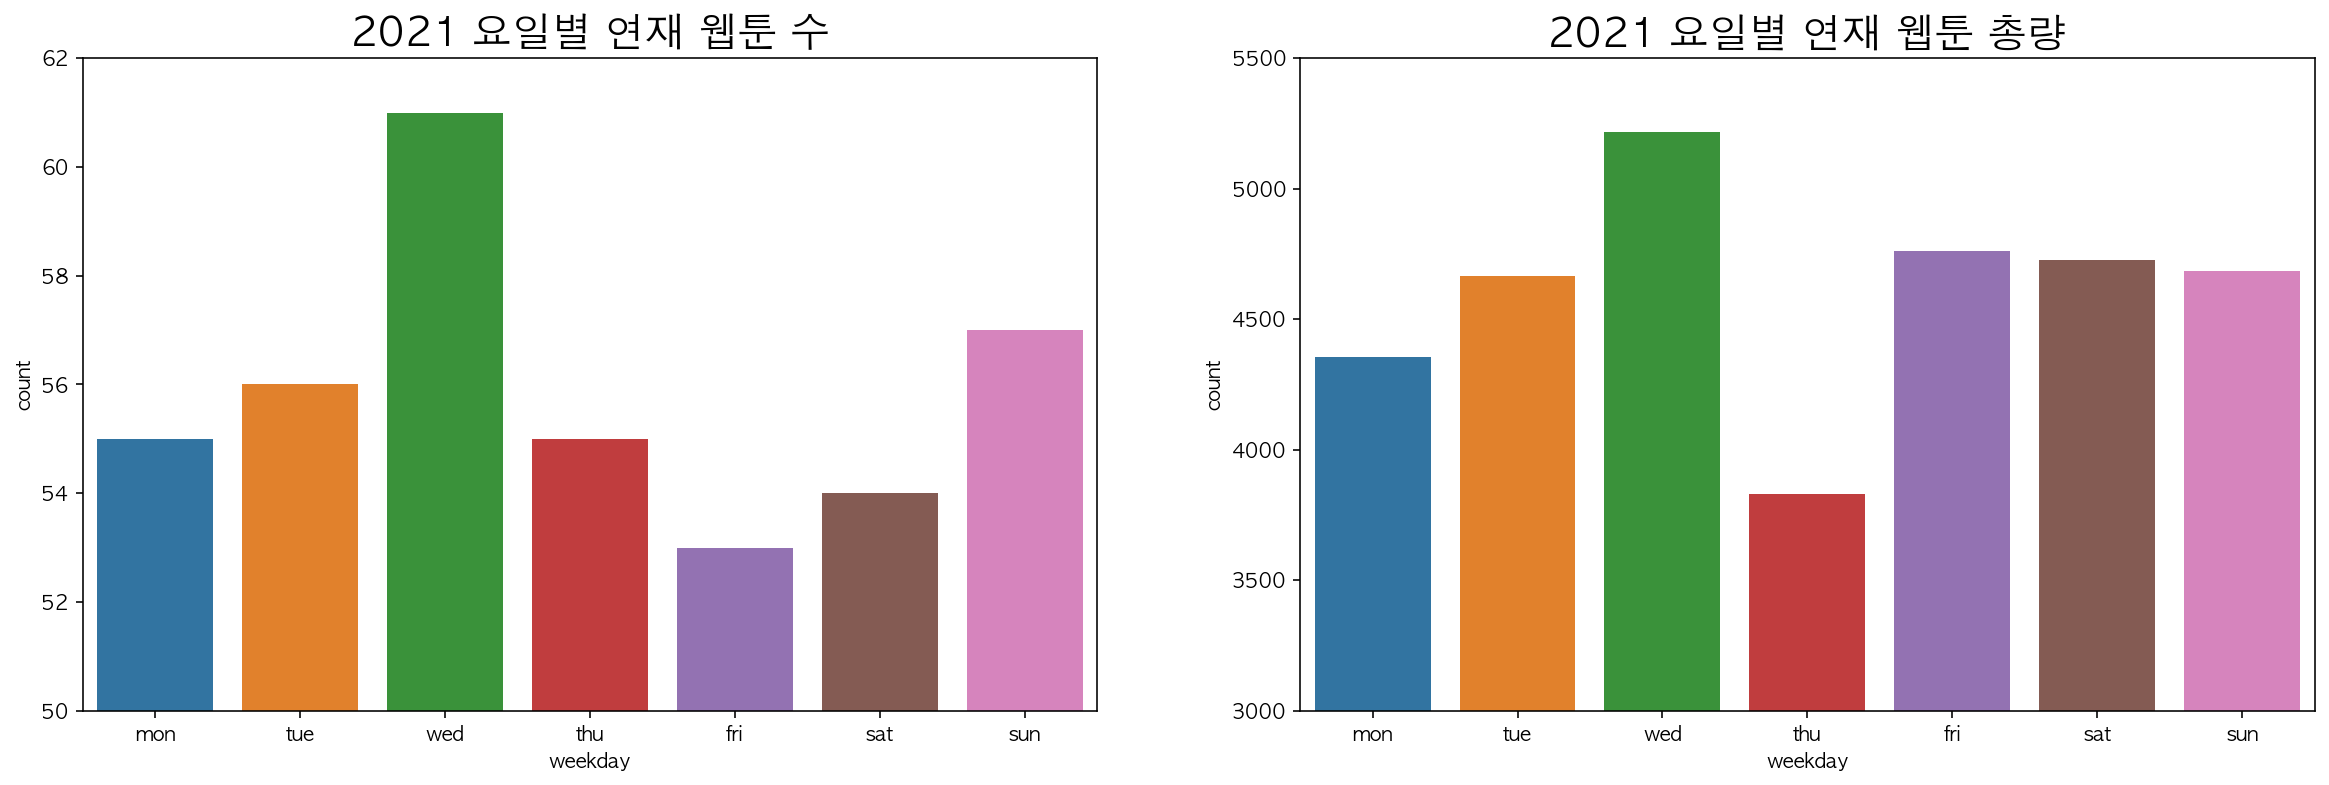

In [14]:
plt.figure(figsize=(20, 6))

plt.subplot(121)
sns.barplot(data=week_len, x='weekday', y='count')
plt.ylim((50, 62))
plt.title("2021 요일별 연재 웹툰 수", fontsize=20)

plt.subplot(122)
sns.barplot(data=week_per_len, x='weekday', y='count')
plt.ylim((3000, 5500))
plt.title("2021 요일별 연재 웹툰 총량", fontsize=20)

plt.show()

-> 수요일의 연재 웹툰 수가 가장 많고 금요일에 가장 적다.

-> 금, 토요일의 웹툰 총량이 웹툰 수에 비해 많은 것을 보아 오래 연재한 웹툰이 분포되어 있다.

#### 장르별 웹툰 수 빈도분석 및 평가지표 시각화

In [15]:
# 장르별 웹툰 수
genre_count = week_genre.groupby('genre').sum().reset_index()
genre_count.sort_values('genre', inplace=True)

# 장르별 웹툰 총량
genre_all_count = weekly_df.groupby('genre').size().reset_index(name='count')
genre_all_count.sort_values('genre', inplace=True)

# 장르별 지표
genre_mean = weekly_df.groupby('genre').agg('mean').round(2)[['star', 'img', 'person']].reset_index()
genre_mean.sort_values('genre', inplace=True)

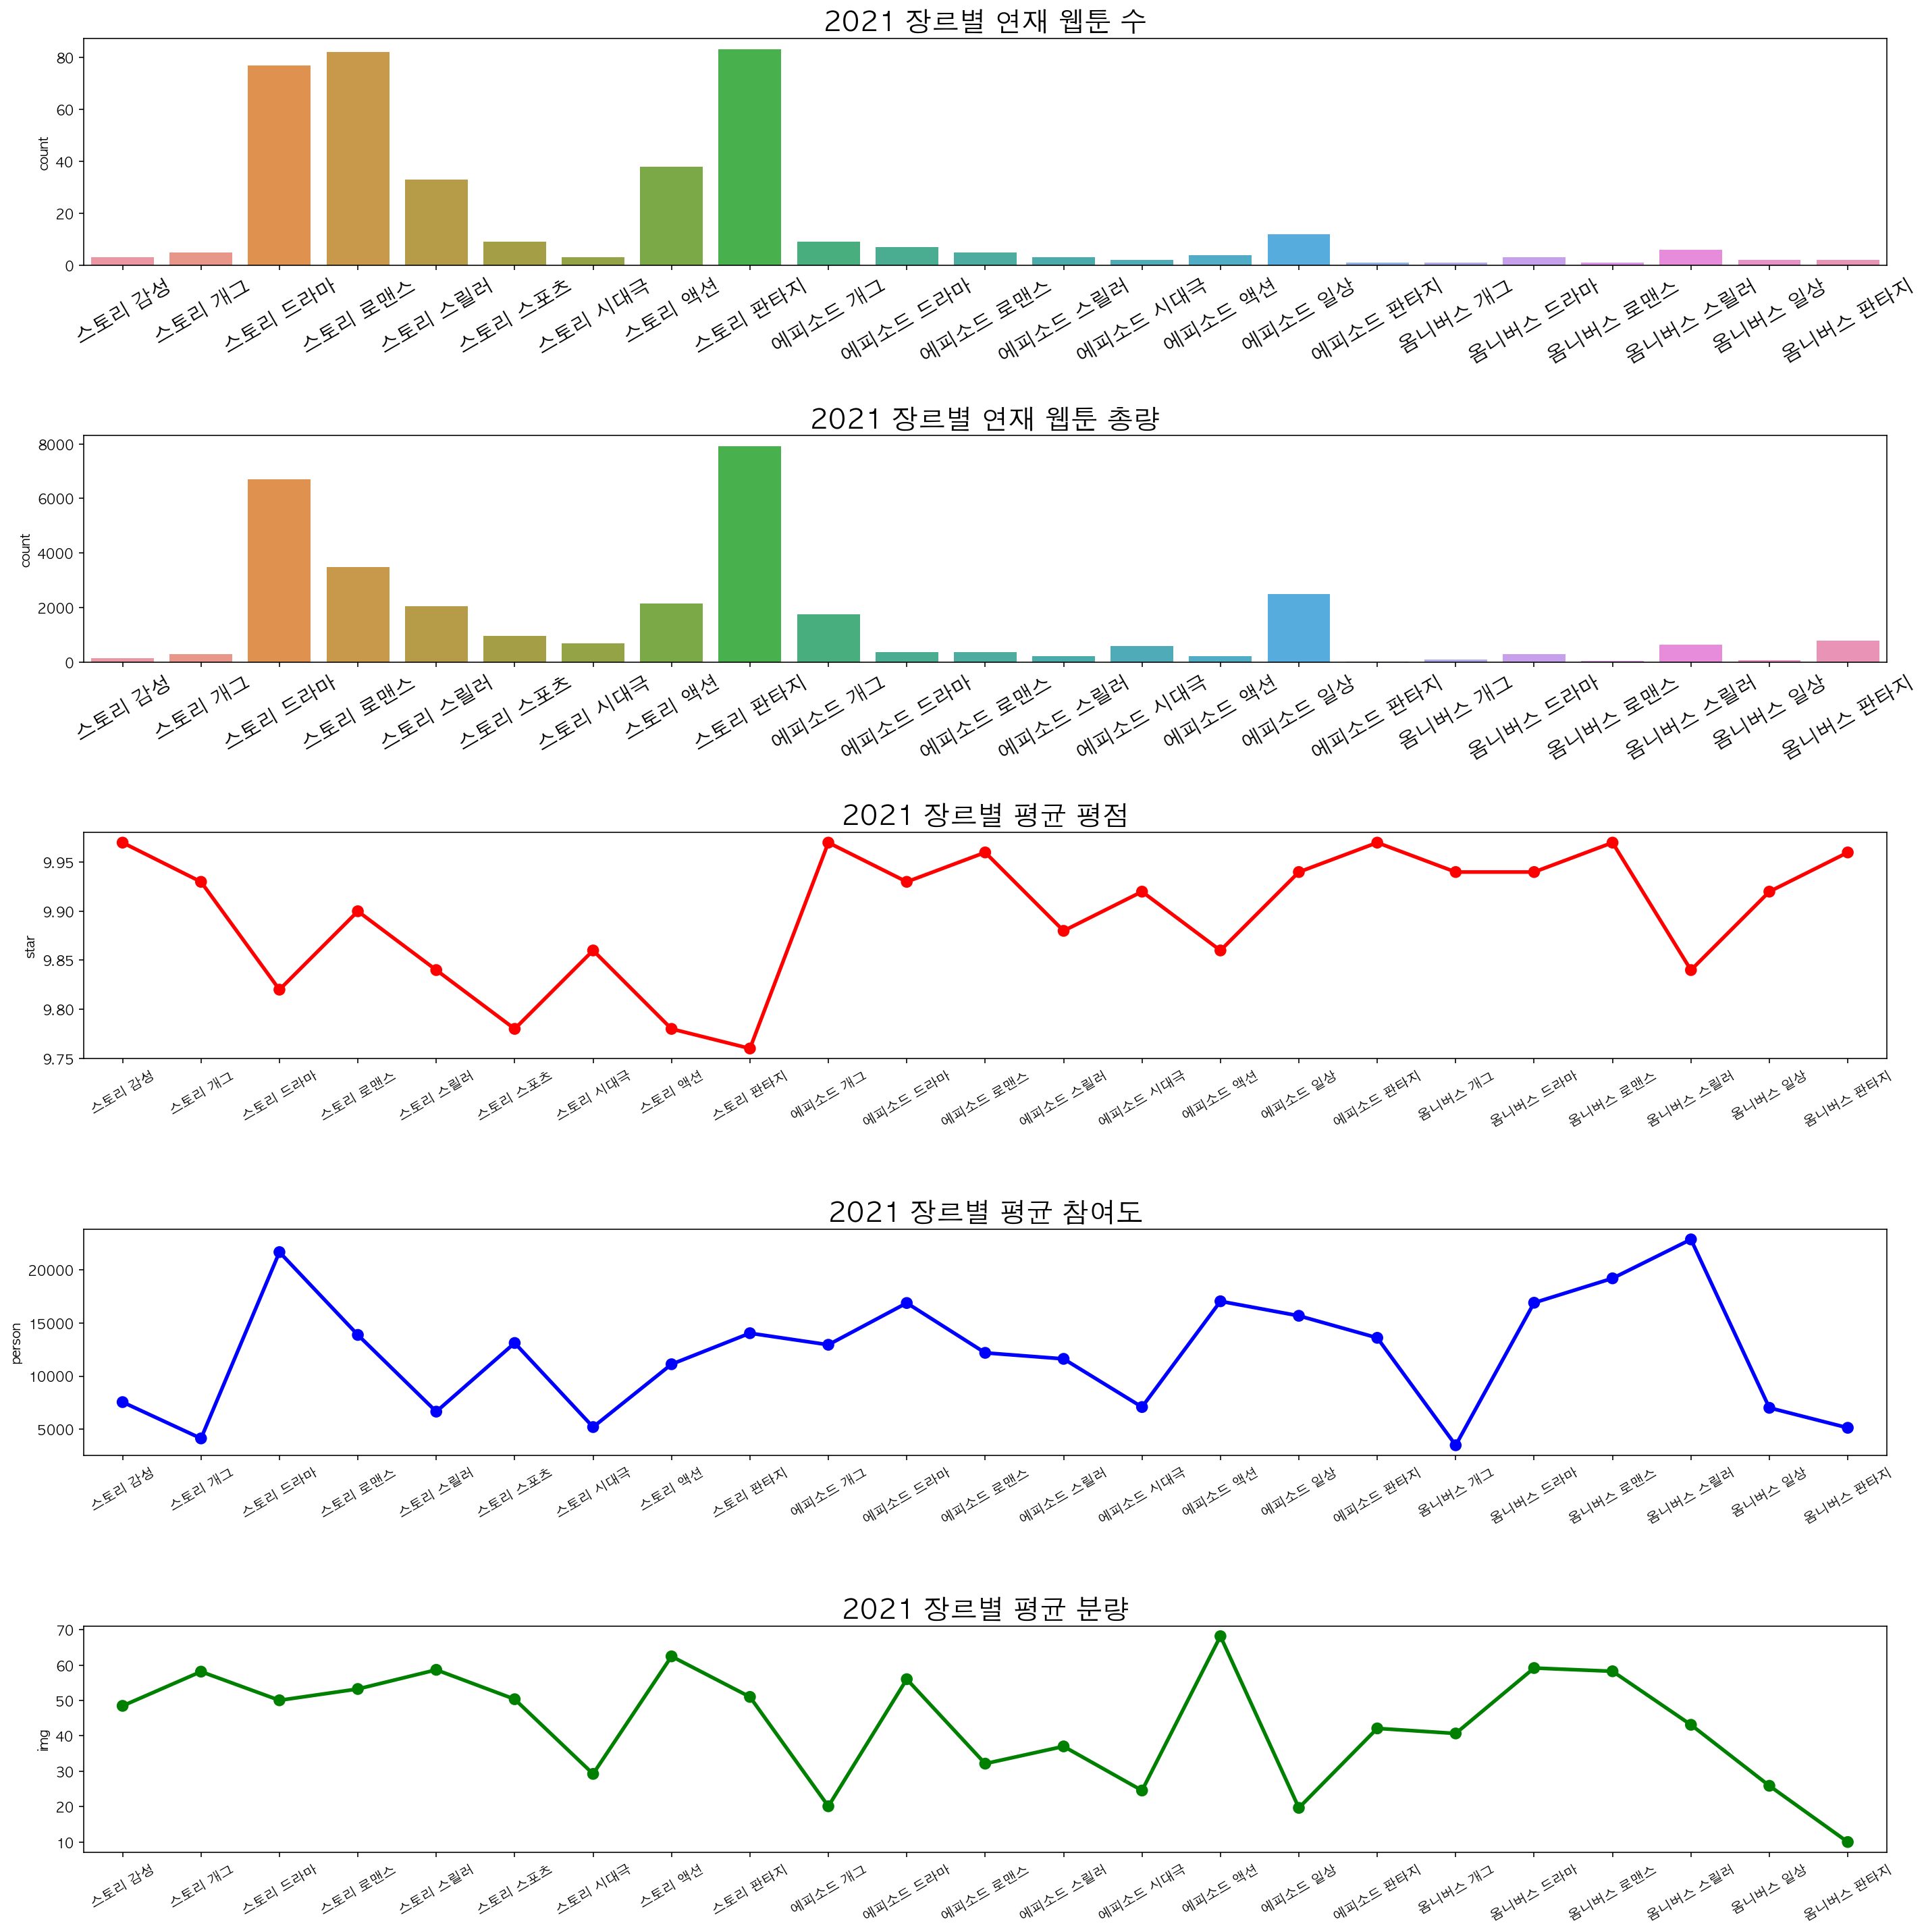

In [16]:
plt.figure(figsize=(20, 20))

plt.subplot(511)
sns.barplot(data=genre_count, x='genre', y='count')
plt.title('2021 장르별 연재 웹툰 수', fontsize=20)
plt.xlabel(None)
plt.xticks(rotation=30, fontsize=15)

plt.subplot(512)
sns.barplot(data=genre_all_count, x='genre', y='count')
plt.title('2021 장르별 연재 웹툰 총량', fontsize=20)
plt.xlabel(None)
plt.xticks(rotation=30, fontsize=15)

plt.subplot(513)
sns.pointplot(data=genre_mean, x='genre', y='star', color='r')
plt.title('2021 장르별 평균 평점', fontsize=20)
plt.xlabel(None)
plt.xticks(rotation=30, fontsize=10)

plt.subplot(514)
sns.pointplot(data=genre_mean, x='genre', y='person', color='b')
plt.title('2021 장르별 평균 참여도', fontsize=20)
plt.xlabel(None)
plt.xticks(rotation=30, fontsize=10)

plt.subplot(515)
sns.pointplot(data=genre_mean, x='genre', y='img', color='g')
plt.title('2021 장르별 평균 분량', fontsize=20)
plt.xlabel(None)
plt.xticks(rotation=30, fontsize=10)

plt.tight_layout(h_pad=3)
plt.show()

-> 장르별 연재 웹툰 수와 총량은 비례한다고 볼 수 있다.

-> 장르별 평균 평점과 평균 참여도가 반비례 관계를 보인다고 추정가능하다.

-> 23개의 독립적인 장르들을 그룹핑하여 수를 줄일 필요가 있다(시각화 어려움)

#### genre 세분화
- genre1 : 큰 카테고리 -> 스토리, 에피소드, 옴니버스
- genre2 : 세부 카테고리 -> 감성, 개그, 드라마, 로맨스, 스릴러, 스포츠, 시대극, 액션, 판타지, 일상

In [17]:
weekly_df['genre1'] = weekly_df['genre'].apply(lambda x: x.split()[0])
weekly_df['genre2'] = weekly_df['genre'].apply(lambda x: x.split()[1])

yearly_df['genre1'] = yearly_df['genre'].apply(lambda x: x.split()[0])
yearly_df['genre2'] =yearly_df['genre'].apply(lambda x: x.split()[1])

weekly_df = weekly_df[['rank', 'title', 'genre', 'genre1', 'genre2', 'star', 'img', 'person', 'datetime', 'year', 'quarter', 'month', 'day', 'weekday']]
yearly_df = yearly_df[['cate_year', 'title', 'genre', 'genre1', 'genre2', 'star', 'img', 'person', 'datetime', 'year', 'quarter', 'month', 'day']]

In [18]:
weekly_df.tail(2)

,rank,title,genre,genre1,genre2,star,img,person,datetime,year,quarter,month,day,weekday
32240,55,호시탐탐,스토리 로맨스,스토리,로맨스,9.85,45,2590,2020-11-14,2020,4,11,14,sun
32241,55,호시탐탐,스토리 로맨스,스토리,로맨스,9.71,45,4257,2020-11-07,2020,4,11,7,sun


In [19]:
yearly_df.tail(2)

,cate_year,title,genre,genre1,genre2,star,img,person,datetime,year,quarter,month,day
331253,2021,9등급 뒤집기,스토리 드라마,스토리,드라마,8.89,64,7815,2019-12-26,2019,4,12,26
331254,2021,9등급 뒤집기,스토리 드라마,스토리,드라마,5.94,89,12699,2019-12-19,2019,4,12,19


#### 카테고리별, 세부장르별 빈도분석

In [20]:
cate_1 = weekly_df.groupby(['weekday', 'title', 'genre1', 'genre2']).size().groupby('genre1').size().reset_index(name='count')
cate_2 = weekly_df.groupby(['weekday', 'title', 'genre1', 'genre2']).size().groupby('genre2').size().reset_index(name='count')
cate_2.sort_values('count', ascending=False, inplace=True)

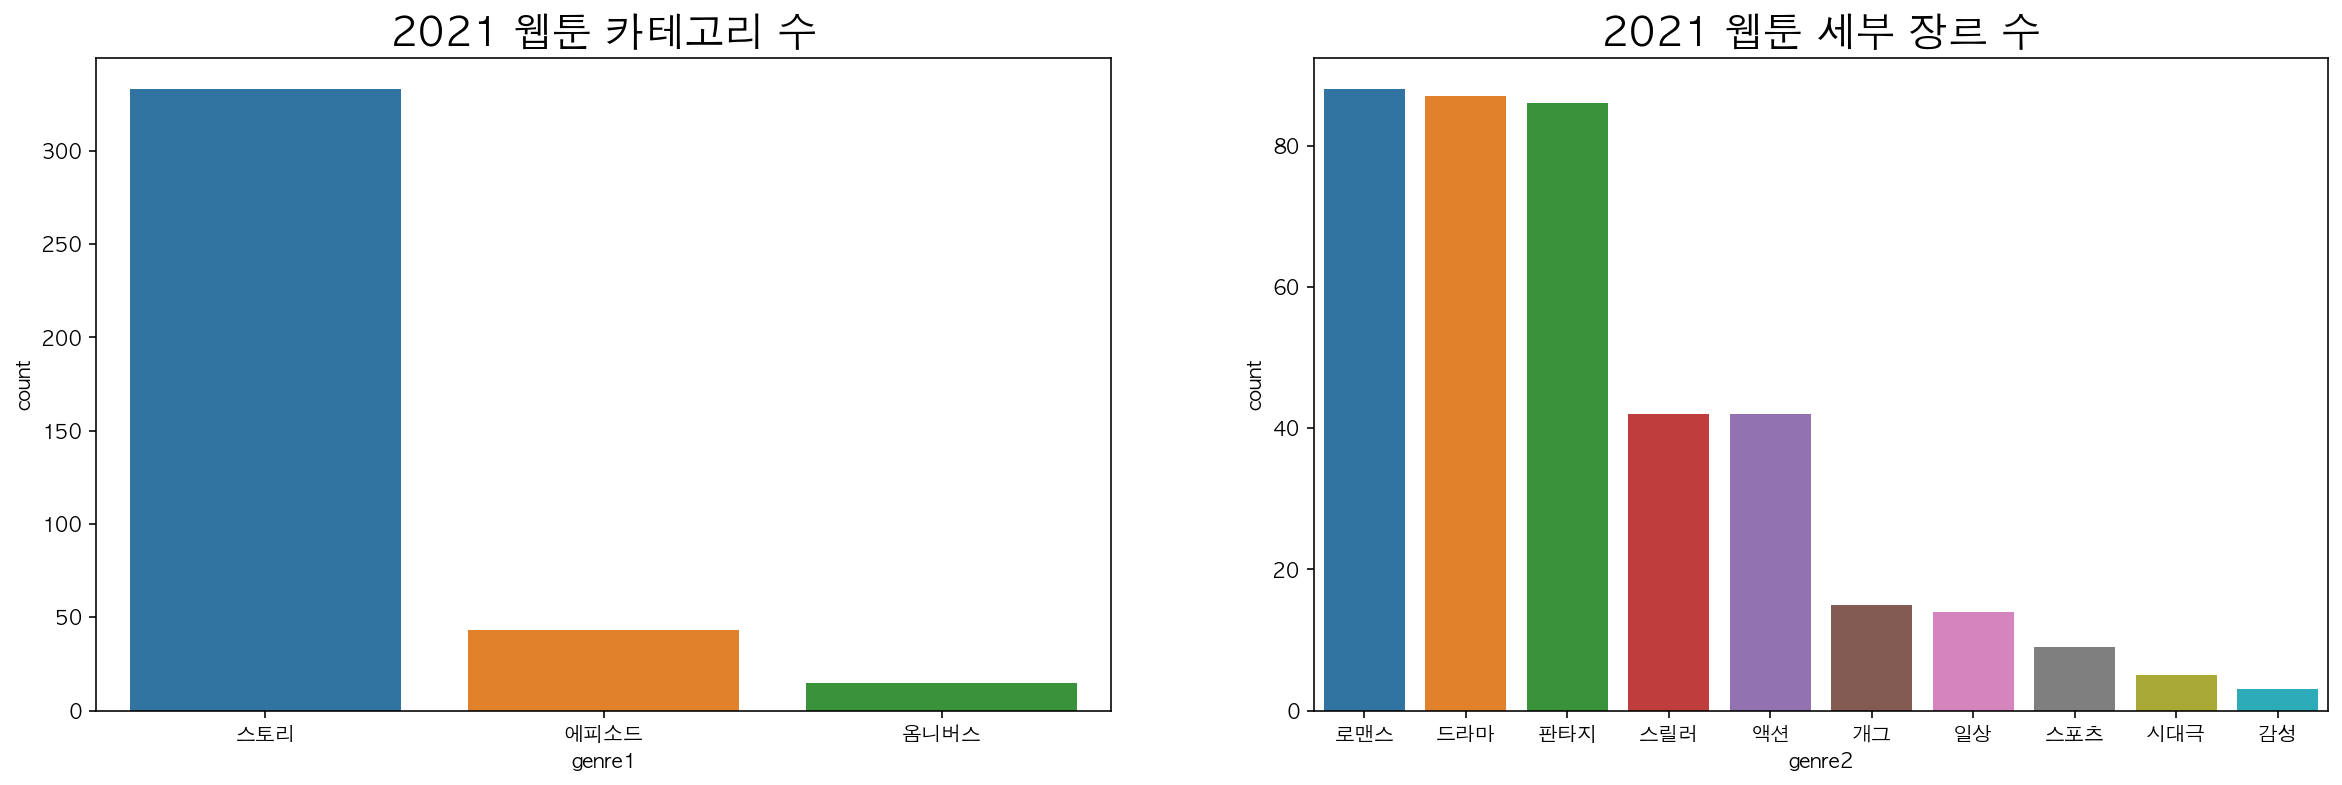

In [21]:
plt.figure(figsize=(20, 6))

plt.subplot(121)
sns.barplot(data=cate_1, x='genre1', y='count')
plt.title('2021 웹툰 카테고리 수', fontsize=20)

plt.subplot(122)
sns.barplot(data=cate_2, x='genre2', y='count')
plt.title('2021 웹툰 세부 장르 수', fontsize=20)

plt.show()

-> 스토리 카테고리가 압도적으로 많고, 세부장르로는 로맨스, 드라마, 판타지 장르 순으로 많다.

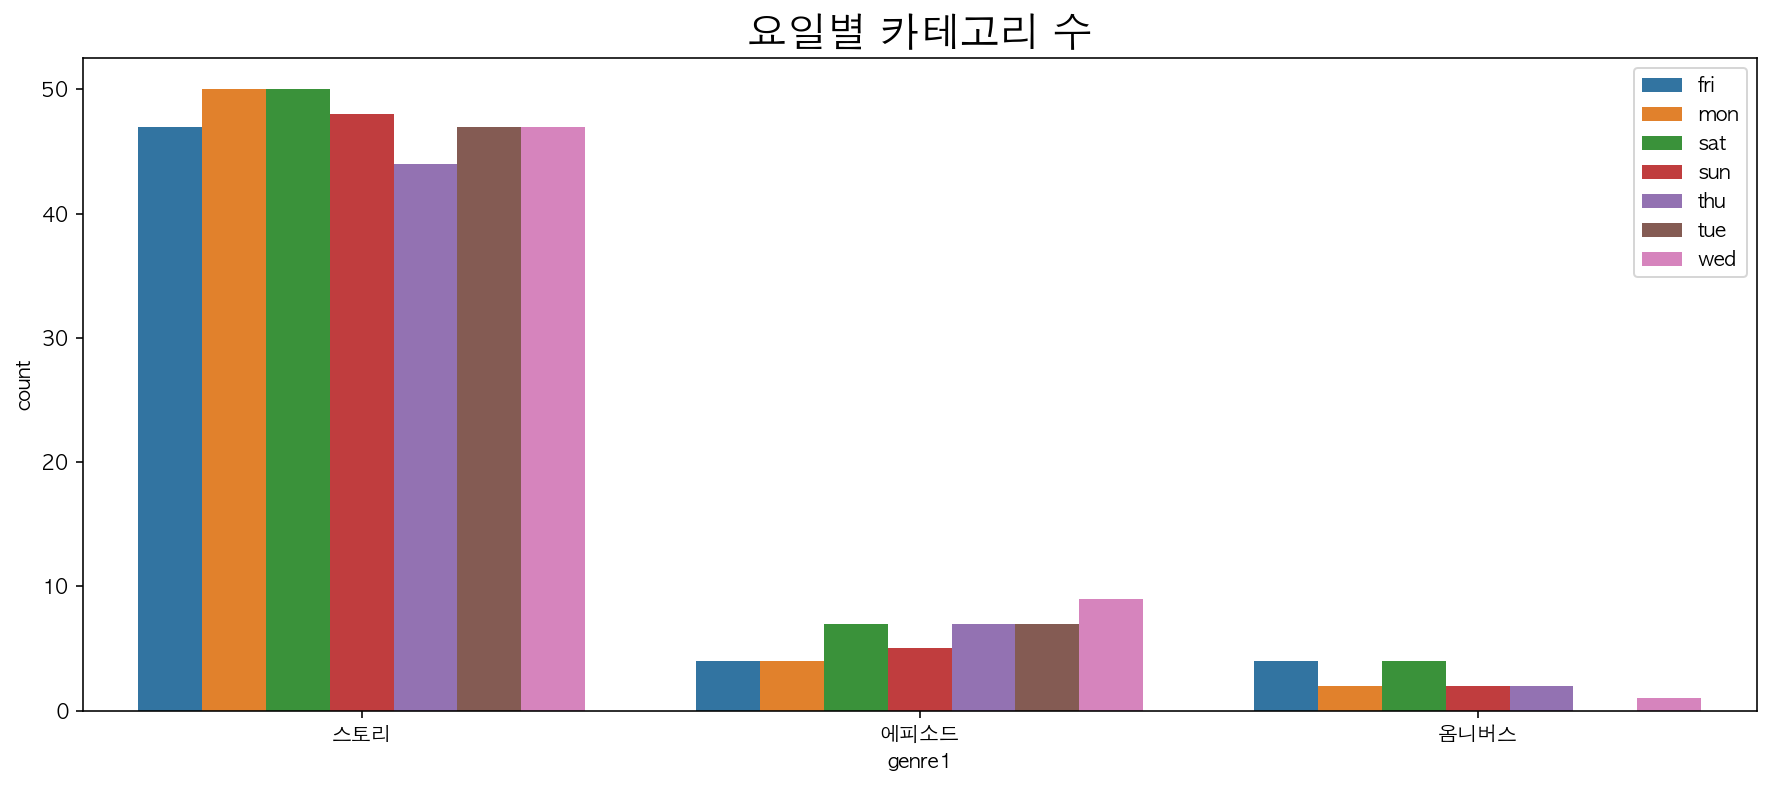

In [22]:
result = weekly_df.groupby(['weekday', 'title', 'genre1']).size().reset_index().groupby(['weekday', 'genre1']).size().reset_index(name='count')

plt.figure(figsize=(15, 6))
sns.barplot(data=result, x='genre1', y='count', hue='weekday')
plt.title('요일별 카테고리 수', fontsize=20)
plt.legend(loc='upper right')
plt.show()

-> 카테고리별로 대체로 고르게 연재되어지고 있다.

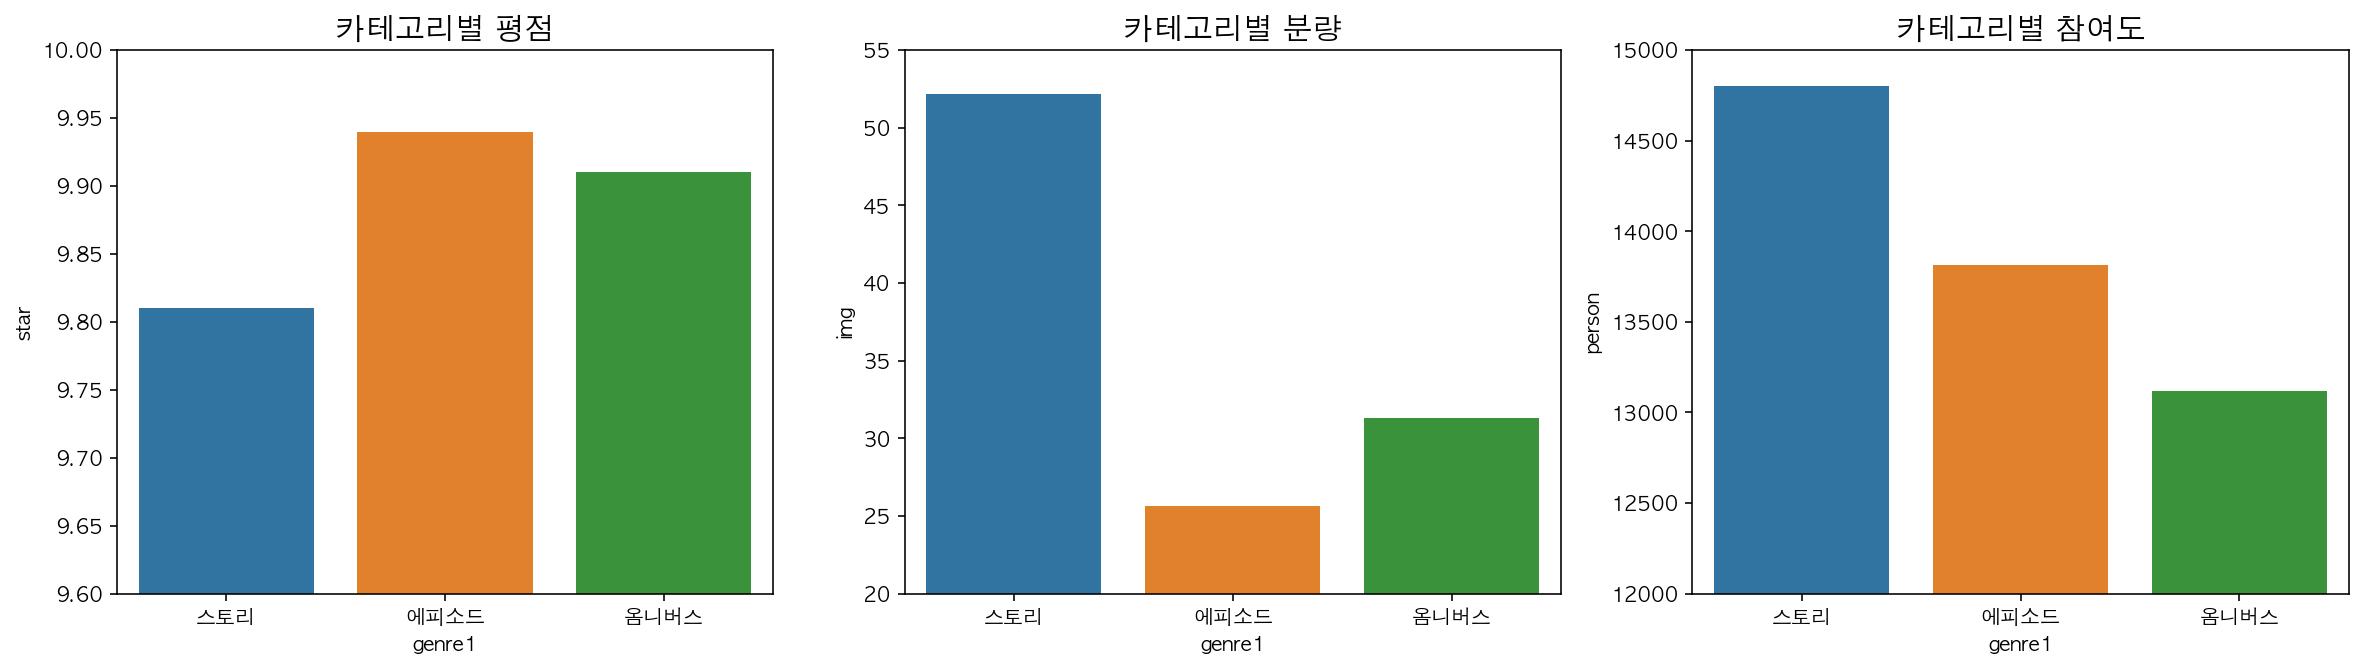

In [23]:
result = weekly_df.groupby('genre1').agg('mean').round(2)[['star', 'img', 'person']].reset_index()


plt.figure(figsize=(20, 5))

plt.subplot(131)
sns.barplot(data=result, x='genre1', y='star')
plt.title('카테고리별 평점', fontsize=15)
plt.ylim((9.6, 10))

plt.subplot(132)
sns.barplot(data=result, x='genre1', y='img')
plt.title('카테고리별 분량', fontsize=15)
plt.ylim((20, 55))

plt.subplot(133)
sns.barplot(data=result, x='genre1', y='person')
plt.title('카테고리별 참여도', fontsize=15)
plt.ylim((12000, 15000))

plt.show()

-> 스토리의 평점이 가장 낮은데 분량과 참여도는 가장 높은 것을 알 수 있다.

-> 에피소드와 옴니버스의 분량이 비교적 적다

    - 옴니버스 : 하나의 장르 속에 서로 다른 독립된 이야기를 묶어 풀어내는 형식
    - 에피소드 : 하나의 큰 주제를 갖고 그 안에서 일어나는 일을 웹툰화 : 시트콤 형식

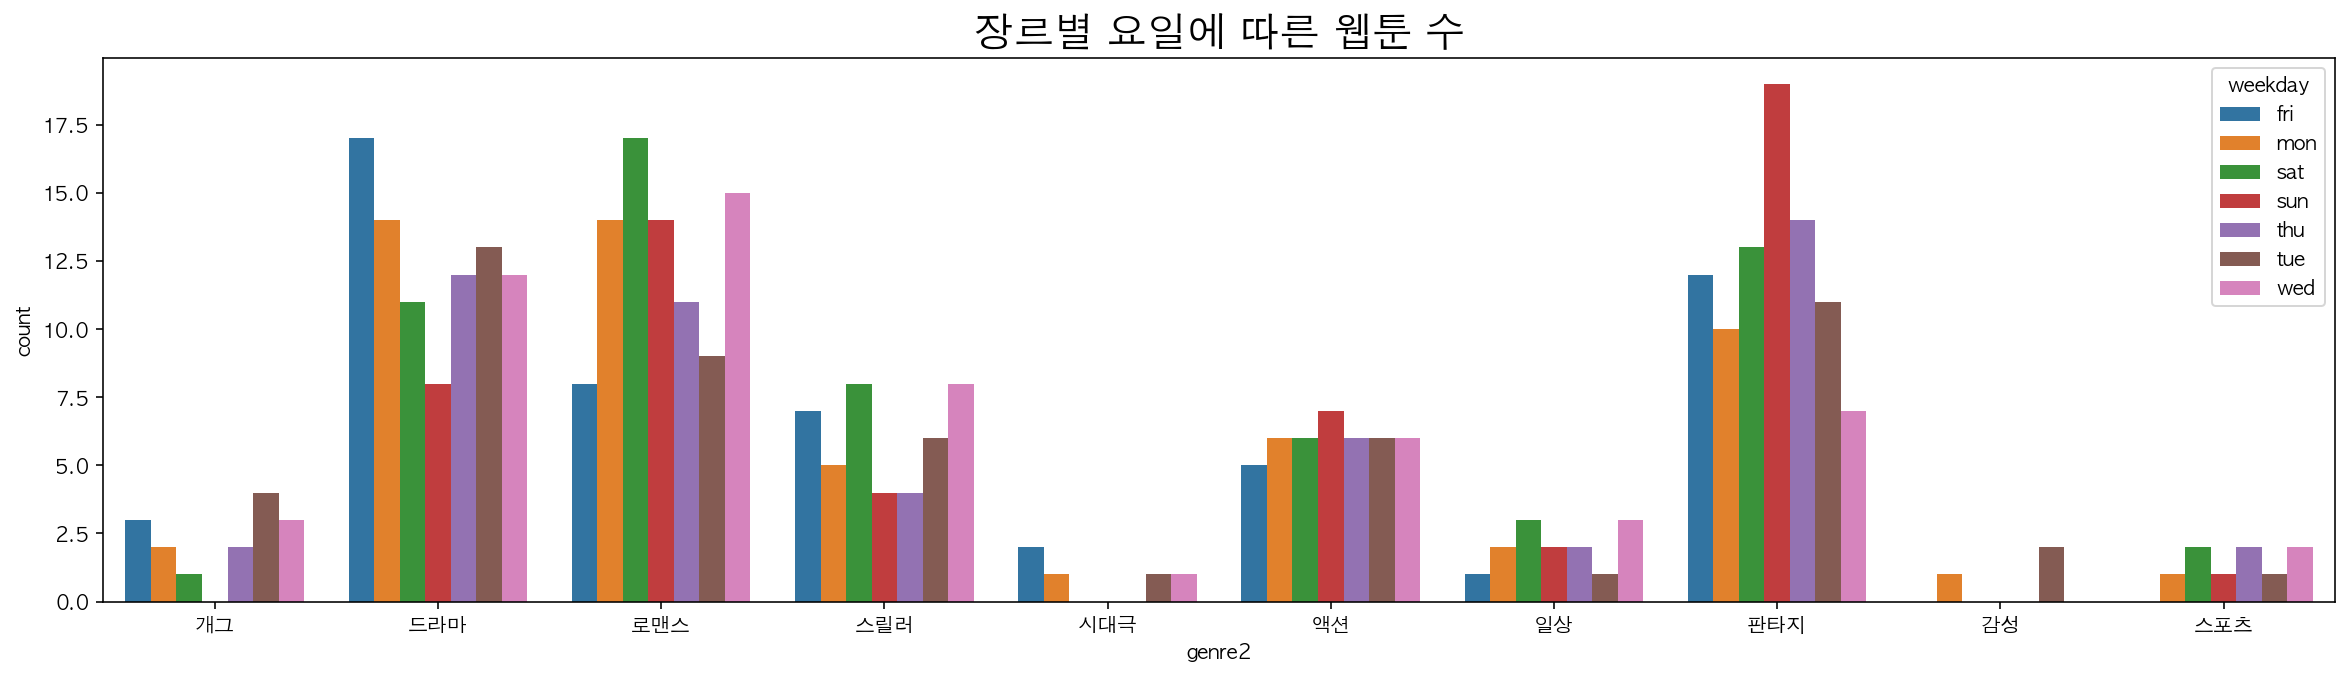

In [24]:
result2 = weekly_df.groupby(['weekday', 'title', 'genre2']).size().reset_index().groupby(['weekday', 'genre2']).size().reset_index(name='count')

plt.figure(figsize=(20, 5))
sns.barplot(data=result2, x='genre2', y='count', hue='weekday')
plt.title('장르별 요일에 따른 웹툰 수', fontsize=20)
plt.show()

-> 대체로 요일별로 눈에 띄는 차이는 없이 고루 분포되어 있다.

-> 판타지는 일요일에 많이 분포되어 있다.

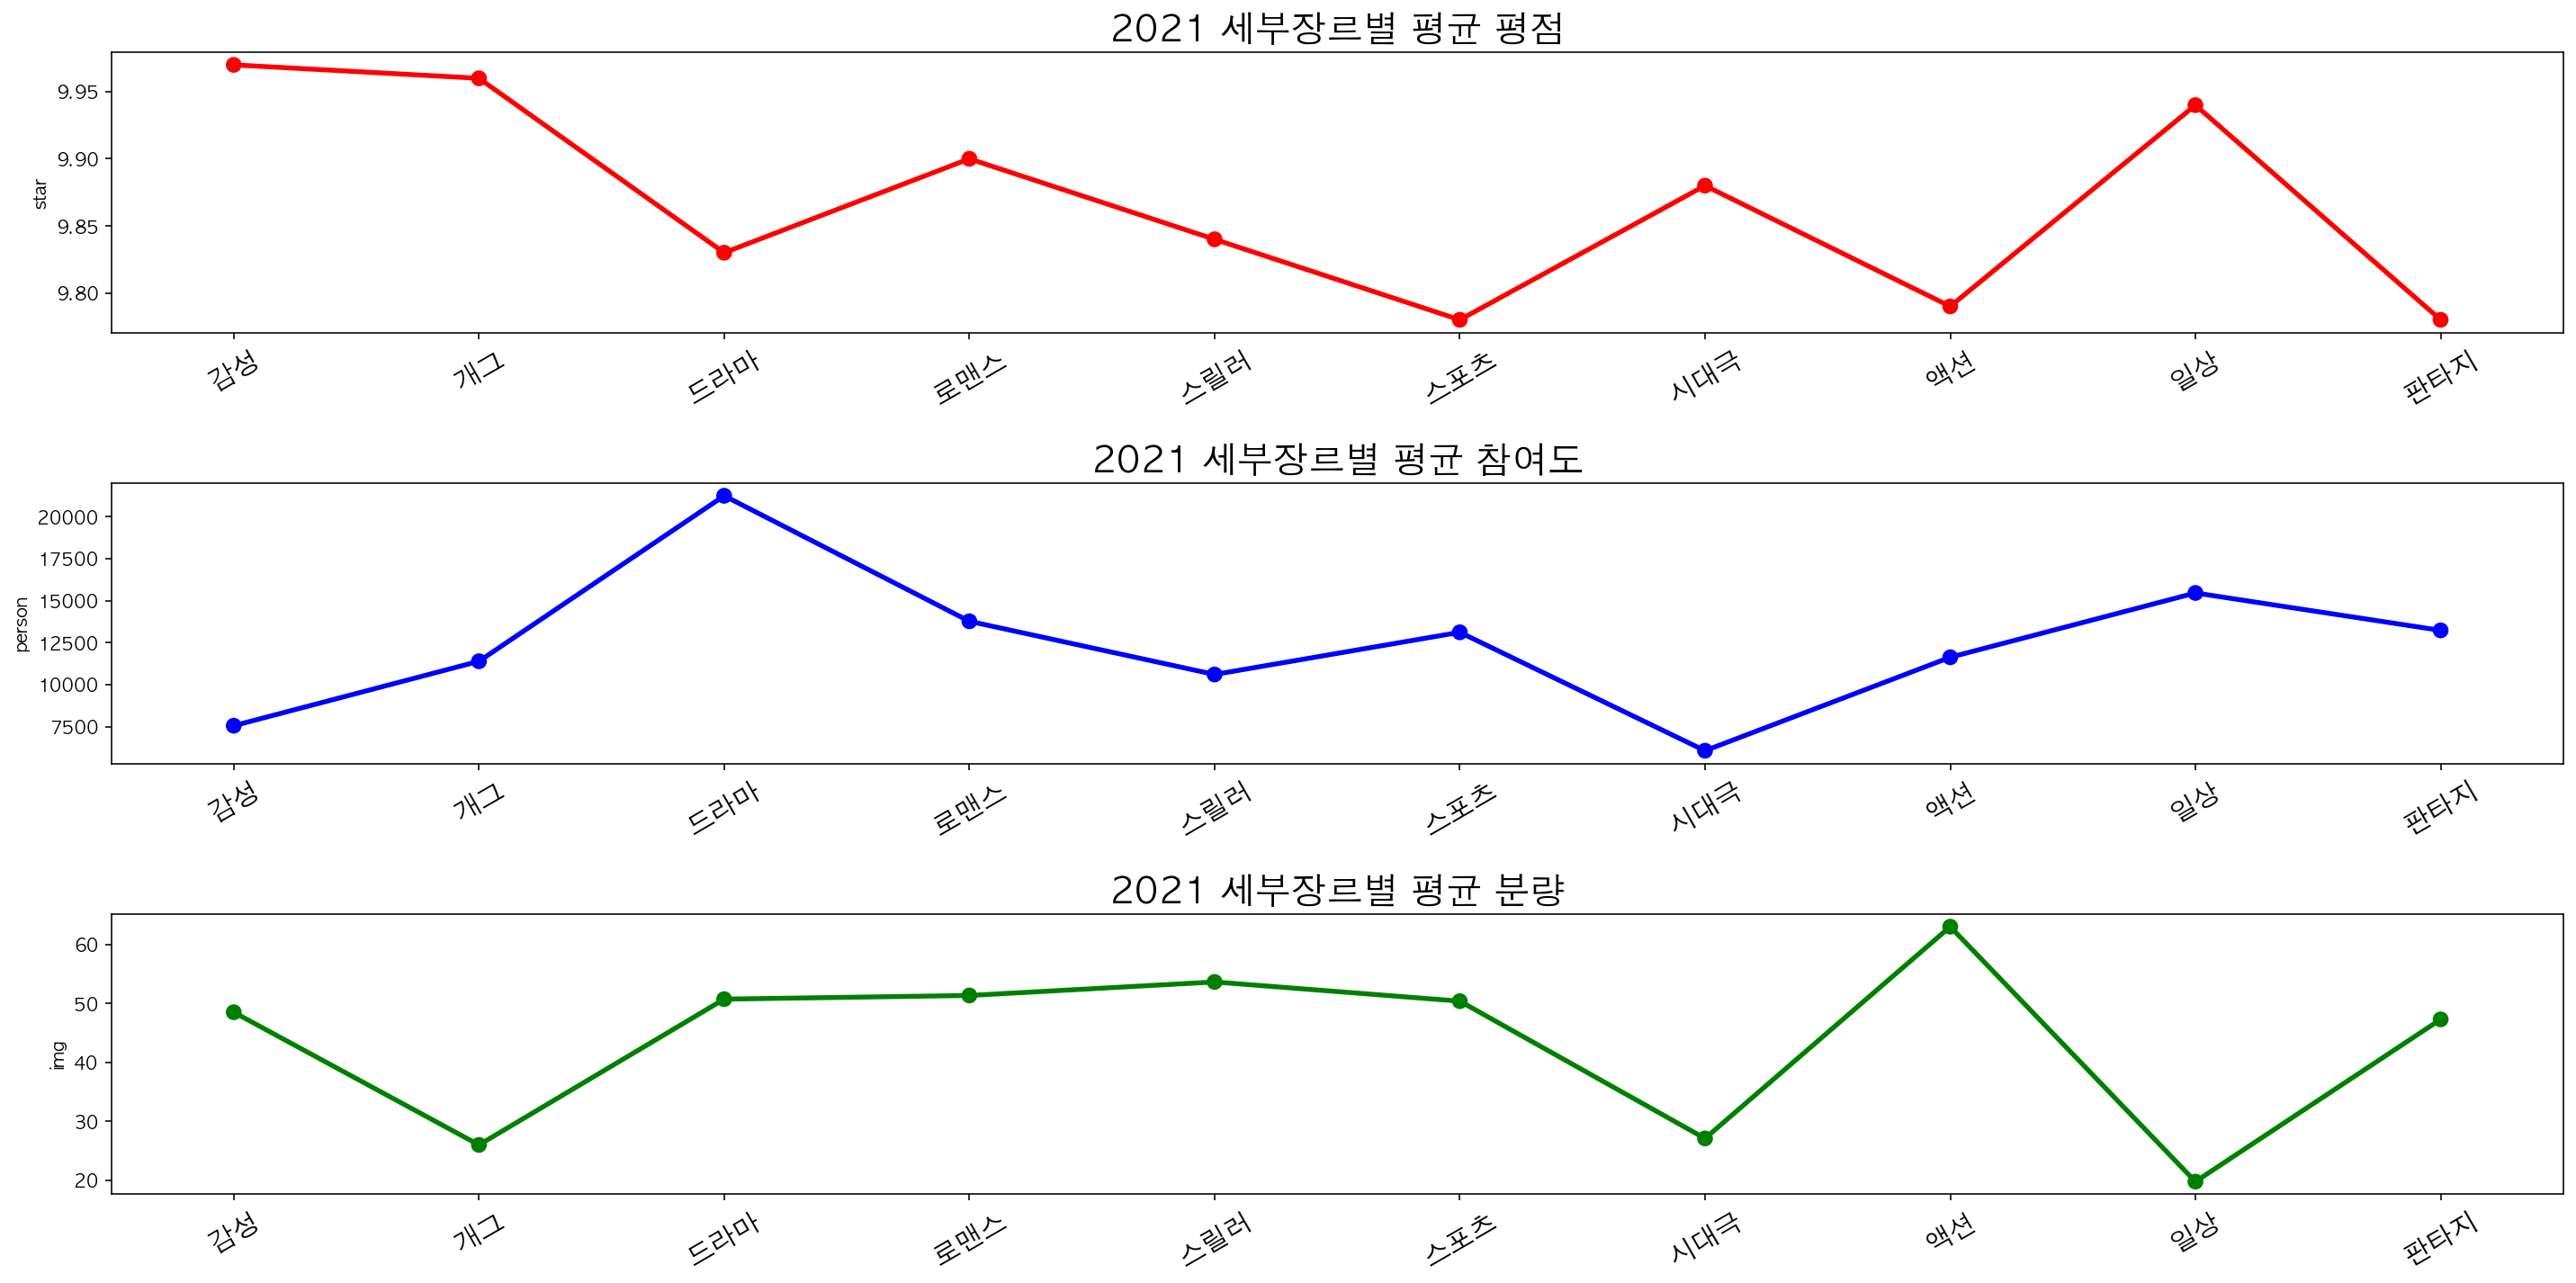

In [25]:
result = weekly_df.groupby('genre2').agg('mean').round(2)[['star', 'img', 'person']].reset_index()

plt.figure(figsize=(20, 10))

plt.subplot(311)
sns.pointplot(data=result, x='genre2', y='star', color='r')
plt.title('2021 세부장르별 평균 평점', fontsize=20)
plt.xlabel(None)
plt.xticks(rotation=30, fontsize=15)

plt.subplot(312)
sns.pointplot(data=result, x='genre2', y='person', color='b')
plt.title('2021 세부장르별 평균 참여도', fontsize=20)
plt.xlabel(None)
plt.xticks(rotation=30, fontsize=15)

plt.subplot(313)
sns.pointplot(data=result, x='genre2', y='img', color='g')
plt.title('2021 세부장르별 평균 분량', fontsize=20)
plt.xlabel(None)
plt.xticks(rotation=30, fontsize=15)

plt.tight_layout(h_pad=2)
plt.show()

-> 평균 평점과 평균 참여도 그래프 간에 반대되는 성향을 보임

### 가설 1. 순위가 높은 웹툰은 평점과 분량과 참여도가 높을 것이다.
- weekly_df의 rank column을 통한 분석

#### weekly_df의 rank의 분포 파악

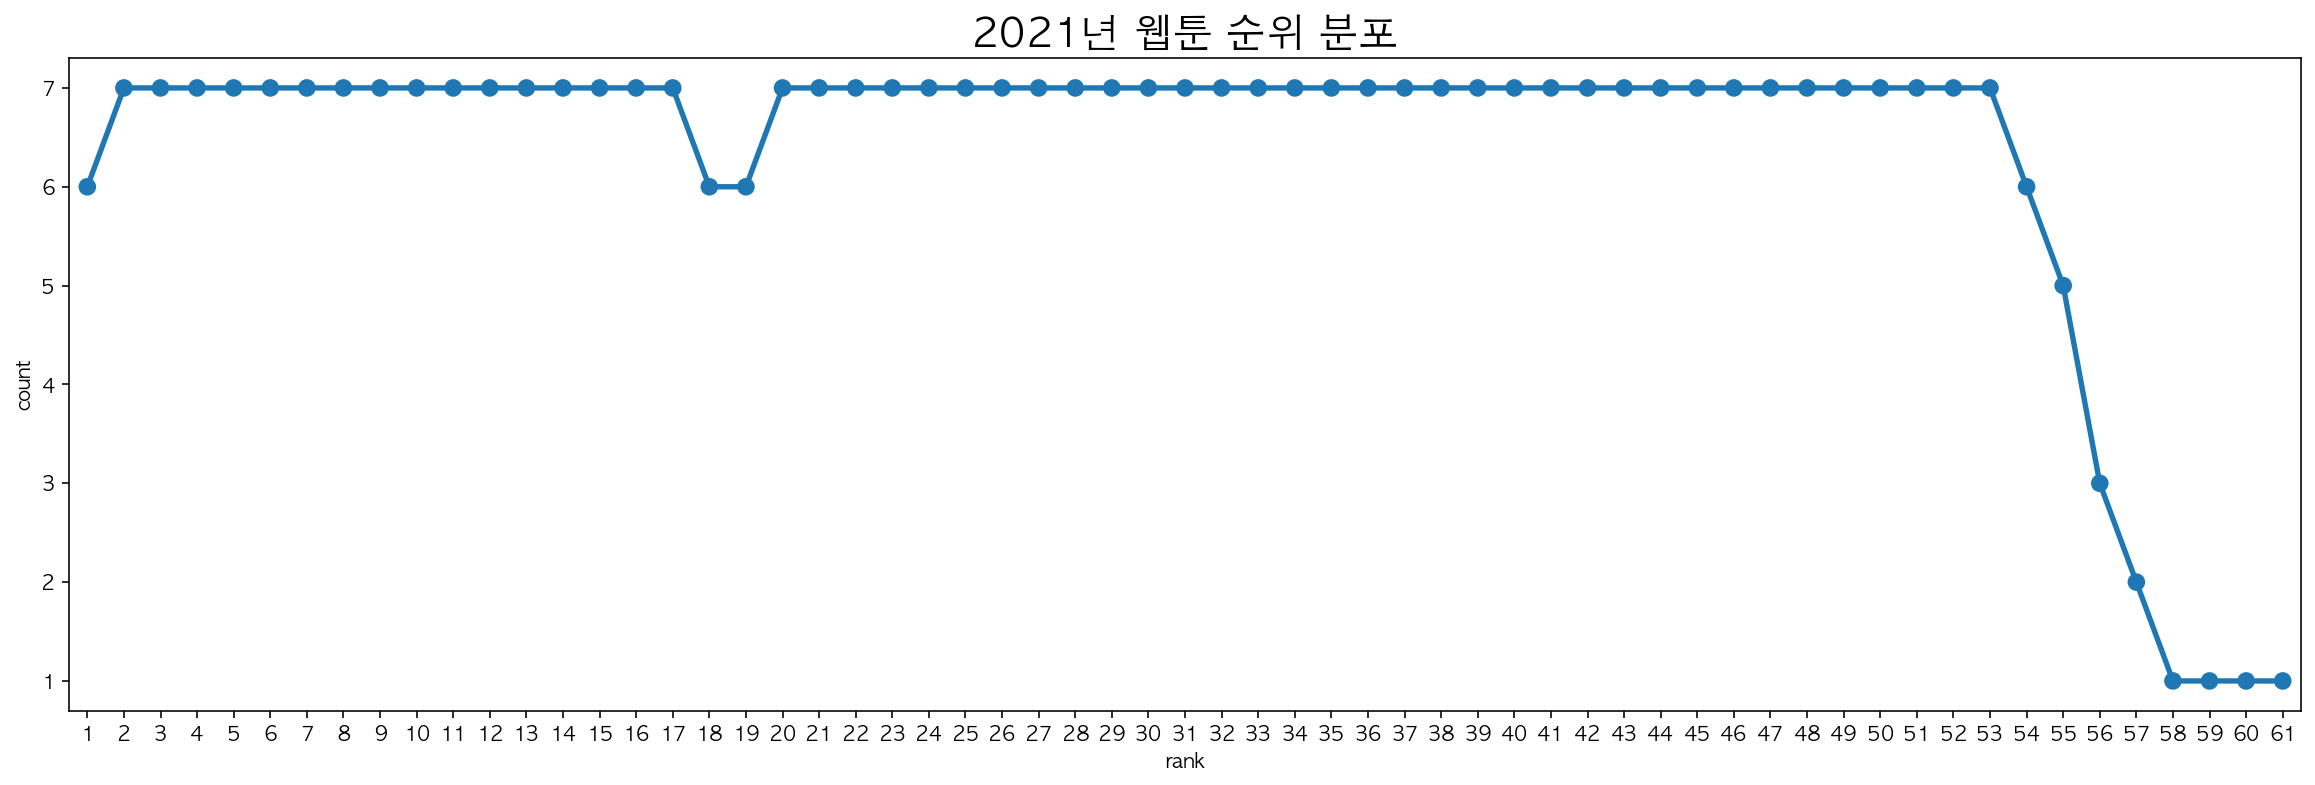

In [26]:
result = weekly_df.groupby(['rank', 'title']).size().reset_index()[['rank', 'title']].groupby('rank').size().reset_index(name='count')

plt.figure(figsize=(20, 6))
sns.pointplot(data=result, x='rank', y='count')
plt.title('2021년 웹툰 순위 분포', fontsize=20)
plt.show()

-> rank <= 53
    
    - count가 6인 rank는 순위가 겹친 웹툰이 존재해서 중복이 제거된 count로 리턴

-> rank > 53

    - 요일별 웹툰의 갯수가 다르기 때문에 점점 감소하는 경향을 보임

#### rank 데이터 타입 변환 및 rank에 대한 score 컬럼 생성
- rank : 1 ~ 61 
    - rank 1 -> 61 - 1 = 60
    - rank 61 -> 61 - 61 = 0

In [33]:
weekly_df['rank'] = weekly_df['rank'].astype('int')
weekly_df['score'] = weekly_df['rank'].apply(lambda x: len(weekly_df['rank'].unique()) - x)
weekly_df

,rank,title,genre,genre1,genre2,star,img,person,datetime,year,quarter,month,day,weekday,score
0,1,참교육,스토리 액션,스토리,액션,9.20,85,33570,2021-03-28,2021,1,3,28,mon,60
1,1,참교육,스토리 액션,스토리,액션,9.70,85,19922,2021-03-21,2021,1,3,21,mon,60
2,1,참교육,스토리 액션,스토리,액션,9.50,82,19273,2021-03-14,2021,1,3,14,mon,60
3,1,참교육,스토리 액션,스토리,액션,9.94,91,20275,2021-03-07,2021,1,3,7,mon,60
4,1,참교육,스토리 액션,스토리,액션,9.95,86,23133,2021-02-28,2021,1,2,28,mon,60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32237,55,호시탐탐,스토리 로맨스,스토리,로맨스,9.86,47,1449,2020-12-05,2020,4,12,5,sun,6
32238,55,호시탐탐,스토리 로맨스,스토리,로맨스,9.78,32,1643,2020-11-28,2020,4,11,28,sun,6
32239,55,호시탐탐,스토리 로맨스,스토리,로맨스,9.79,43,2134,2020-11-21,2020,4,11,21,sun,6
32240,55,호시탐탐,스토리 로맨스,스토리,로맨스,9.85,45,2590,2020-11-14,2020,4,11,14,sun,6


In [34]:
# 순위에 따른 각 웹툰의 제목, 카테고리, 세부장르와 평균평점, 분량, 참여도와 점수를 가진 table 생성
result = weekly_df.groupby(['rank', 'title', 'genre1', 'genre2']).agg('mean').round(2).reset_index()[['rank', 'title', 'genre1', 'genre2', 'star', 'img', 'person', 'score']]
result

,rank,title,genre1,genre2,star,img,person,score
0,1,고수,스토리,판타지,9.96,70.55,42684.62,60.0
1,1,독립일기,에피소드,일상,9.97,14.35,28734.61,60.0
2,1,여신강림,스토리,로맨스,9.51,75.29,44934.14,60.0
3,1,외모지상주의,스토리,드라마,9.47,77.53,56701.43,60.0
4,1,참교육,스토리,액션,9.77,83.73,24527.05,60.0
...,...,...,...,...,...,...,...,...
383,57,인간졸업,스토리,드라마,9.77,73.27,1200.19,4.0
384,58,먹지마세요,스토리,판타지,9.93,45.78,2699.19,3.0
385,59,누군가의 로섬,스토리,드라마,9.95,58.98,2680.23,2.0
386,60,함부로 대해줘,스토리,로맨스,9.93,50.74,2250.87,1.0


In [35]:
# 점수에 따른 평균 평점, 분량, 참여도 table 생성
corr_df =result.groupby('score').agg('mean').round(3).reset_index()[['score', 'star', 'img', 'person']]
corr_df

,score,star,img,person
0,0.0,9.660,42.030,1537.070
1,1.0,9.930,50.740,2250.870
2,2.0,9.950,58.980,2680.230
3,3.0,9.930,45.780,2699.190
4,4.0,9.835,74.660,1432.830
...,...,...,...,...
56,56.0,9.874,57.664,24418.497
57,57.0,9.907,43.110,22710.666
58,58.0,9.917,57.000,22395.884
59,59.0,9.859,67.560,31911.181


In [36]:
# 위 table의 각 컬럼간 상관계수
corr_df.corr()

,score,star,img,person
score,1.000000,0.051074,0.085291,0.808646
star,0.051074,1.000000,-0.179338,0.014832
img,0.085291,-0.179338,1.000000,0.087896
person,0.808646,0.014832,0.087896,1.000000


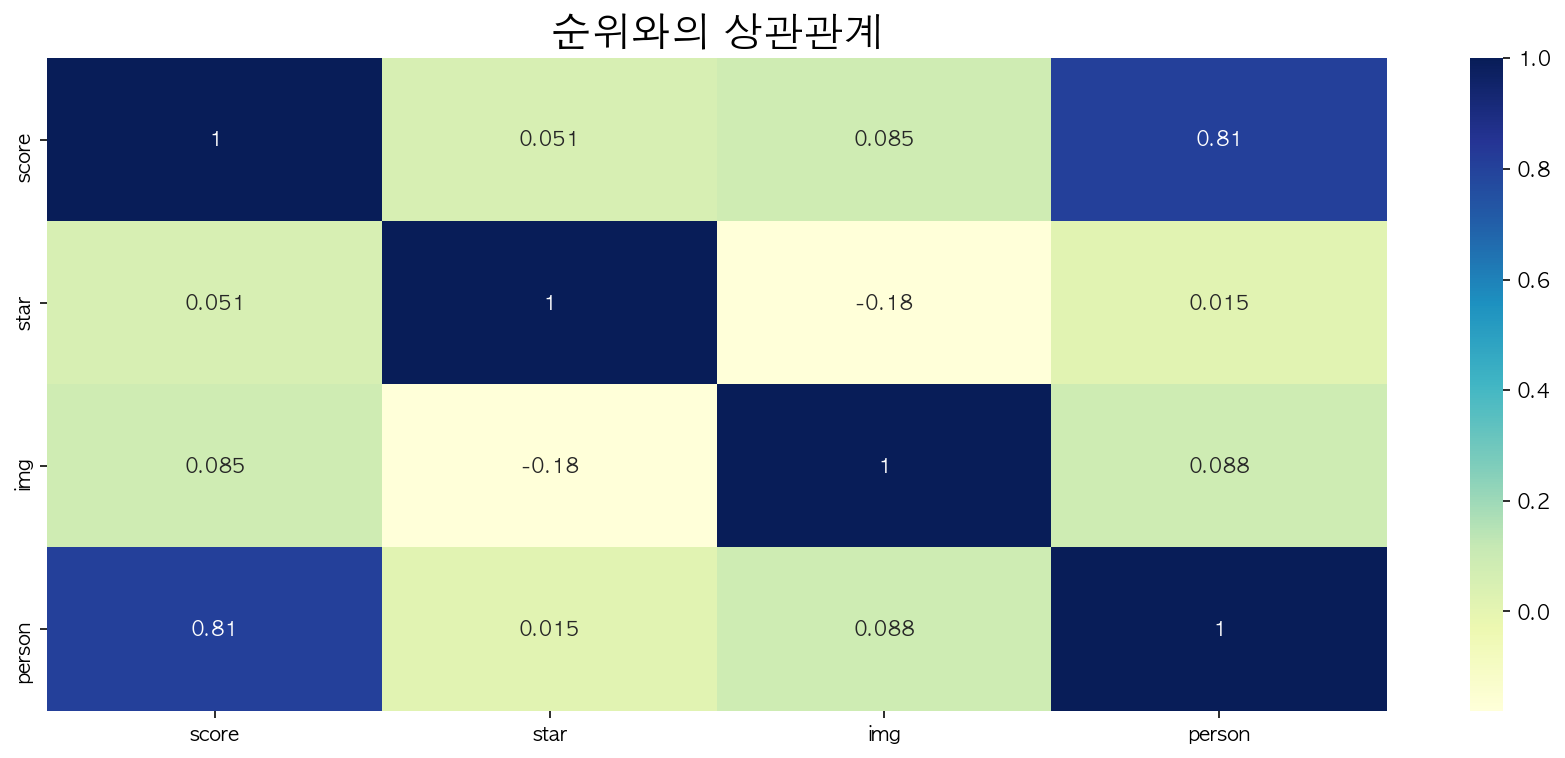

In [37]:
plt.figure(figsize=(15, 6))
sns.heatmap(corr_df.corr(), annot=True, cmap="YlGnBu")
plt.title('순위와의 상관관계', fontsize=20)
plt.show()

-> score와 person간의 상관계수가 0.81로 강한 양의 상관관계가 있음을 알 수 있다.

    - 따라서 순위가 높을수록 참여도가 높다고 할 수 있다.
    - 순위와 평점, 분량을 관계가 없다고 할 수 있다.

#### 카테고리별로 score 세분화
- 각 카테고리별로 score와 평가지표간의 상관관계를 파악해 좀 더 구체적인 인사이트 도출

In [38]:
# 카테고리에 따른 점수별 평균 평점, 분량, 참여도 table
df = result.groupby(['genre1', 'score']).agg('mean').reset_index()[['genre1', 'score', 'star', 'img', 'person']].sort_values(['score', 'genre1'], ascending=False).round(3)
df.head()

,genre1,score,star,img,person
89,에피소드,60.0,9.970,14.350,28734.610
59,스토리,60.0,9.722,70.260,42316.132
58,스토리,59.0,9.859,67.560,31911.181
88,에피소드,58.0,9.940,41.080,18298.255
57,스토리,58.0,9.908,63.368,24034.936


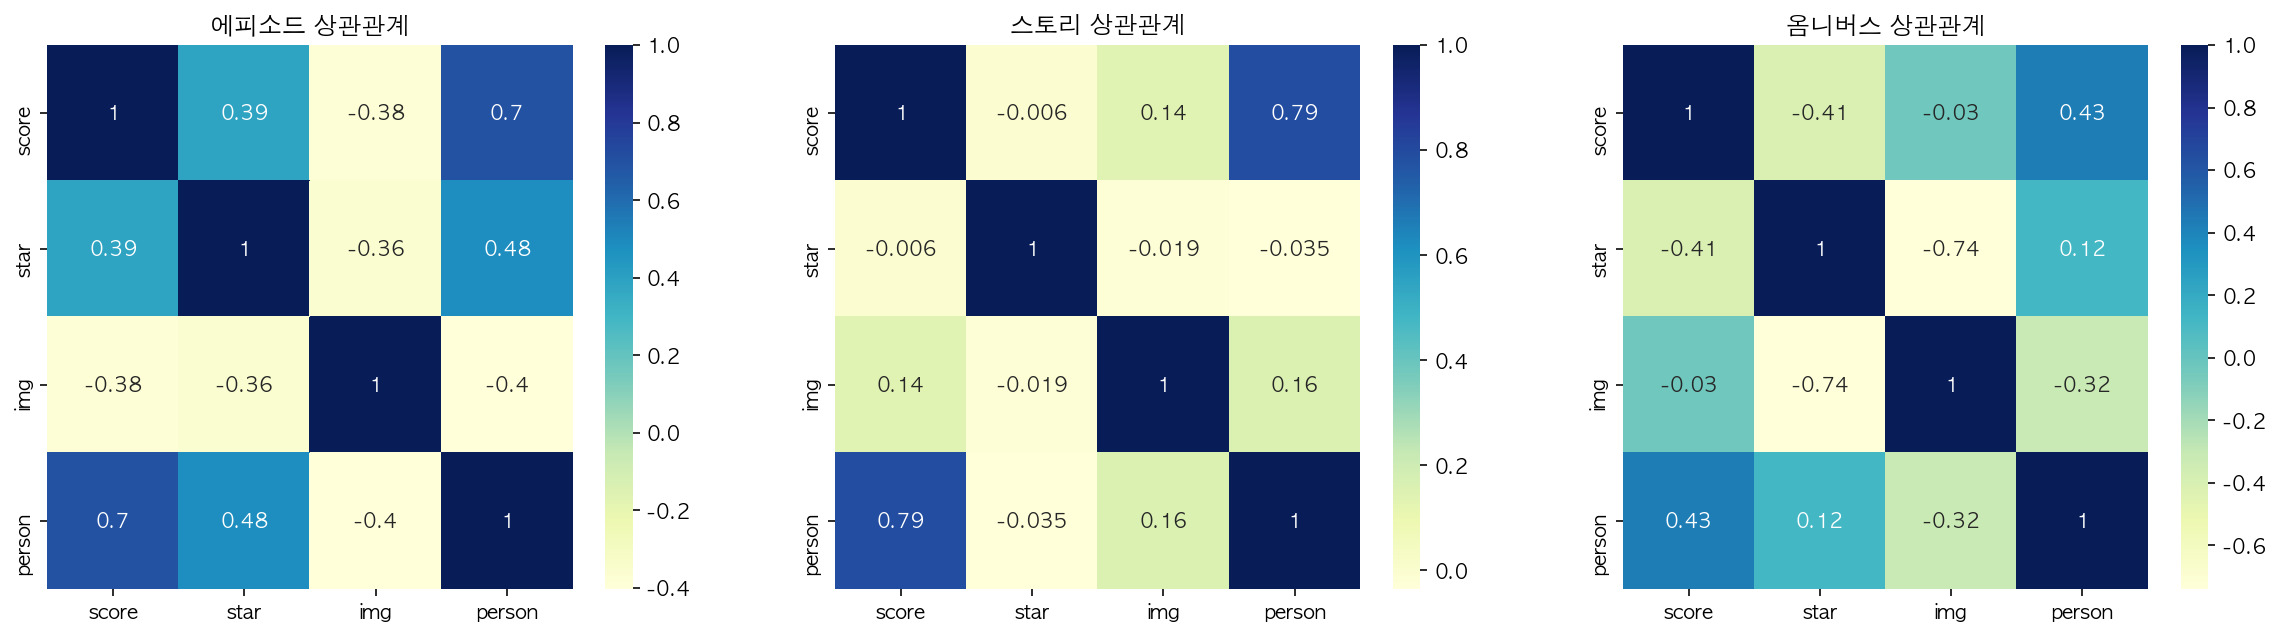

In [39]:
corr_ls = []
for idx in range(len(df['genre1'].unique())):
    corr = df[df['genre1'] == df['genre1'].unique()[idx]].corr()
    corr_ls.append(corr)
    

plt.figure(figsize=(20, 5))

plt.subplot(131)
sns.heatmap(corr_ls[0], annot=True, cmap="YlGnBu");
plt.title('에피소드 상관관계')

plt.subplot(132)
sns.heatmap(corr_ls[1], annot=True, cmap="YlGnBu");
plt.title('스토리 상관관계')

plt.subplot(133)
sns.heatmap(corr_ls[2], annot=True, cmap="YlGnBu");
plt.title('옴니버스 상관관계')

plt.show()

- 에피소드
    - 평점 : 약한 양의 상관관계
    - 분량 : 약한 음의 상관관계

- 스토리
    - 평점, 분량 모두 score와 관계가 없다고 할 수 있다.

- 옴니버스
    - 평점 : 약한 음의 상관관계
    - 분량 : 관계가 없다고 할 수 있다.
    
-> 에피소드와 스토리는 참여도와 강한 양의 상관관계가 있지만, 옴니버스는 약한 양의 상관관계를 갖는 것을 알 수 있다.

### yearly dataframe 빈도분석

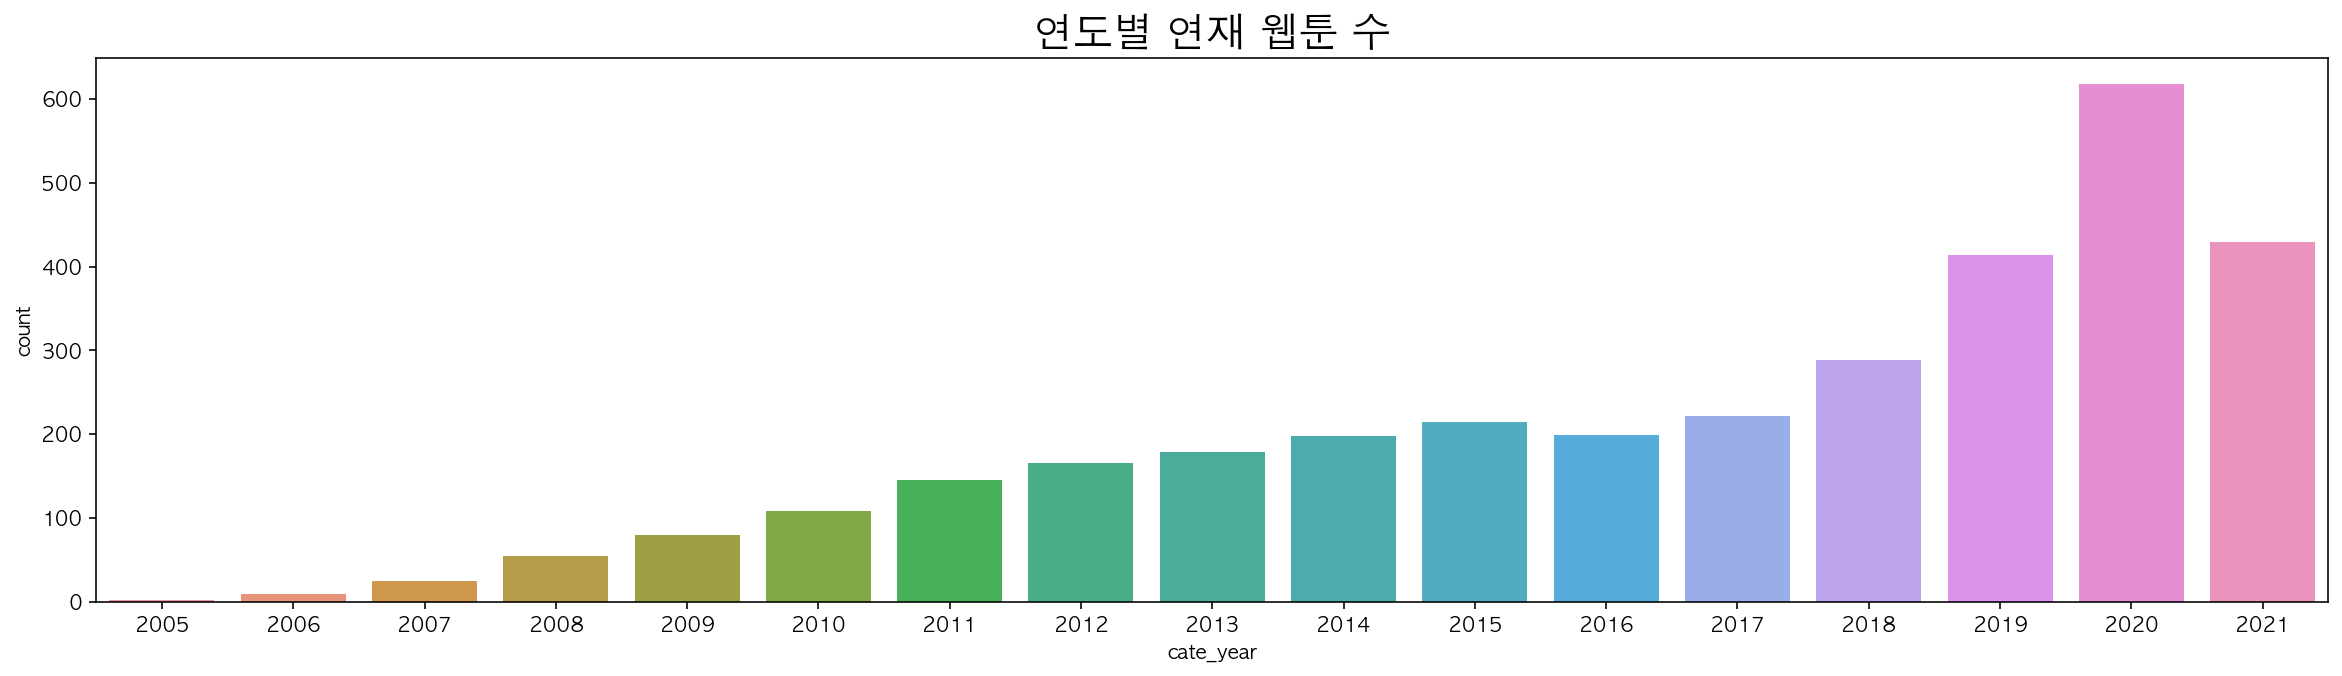

In [40]:
result = yearly_df.groupby(['cate_year', 'title']).size().reset_index().groupby('cate_year').size().reset_index(name='count')

plt.figure(figsize=(20, 5))
sns.barplot(data=result, x='cate_year', y='count');
plt.title('연도별 연재 웹툰 수', fontsize=20);

-> 해마다 웹툰시장이 커지고 있다.

-> 2021년은 4월까지의 데이터밖에 없기 때문에 count가 적다.

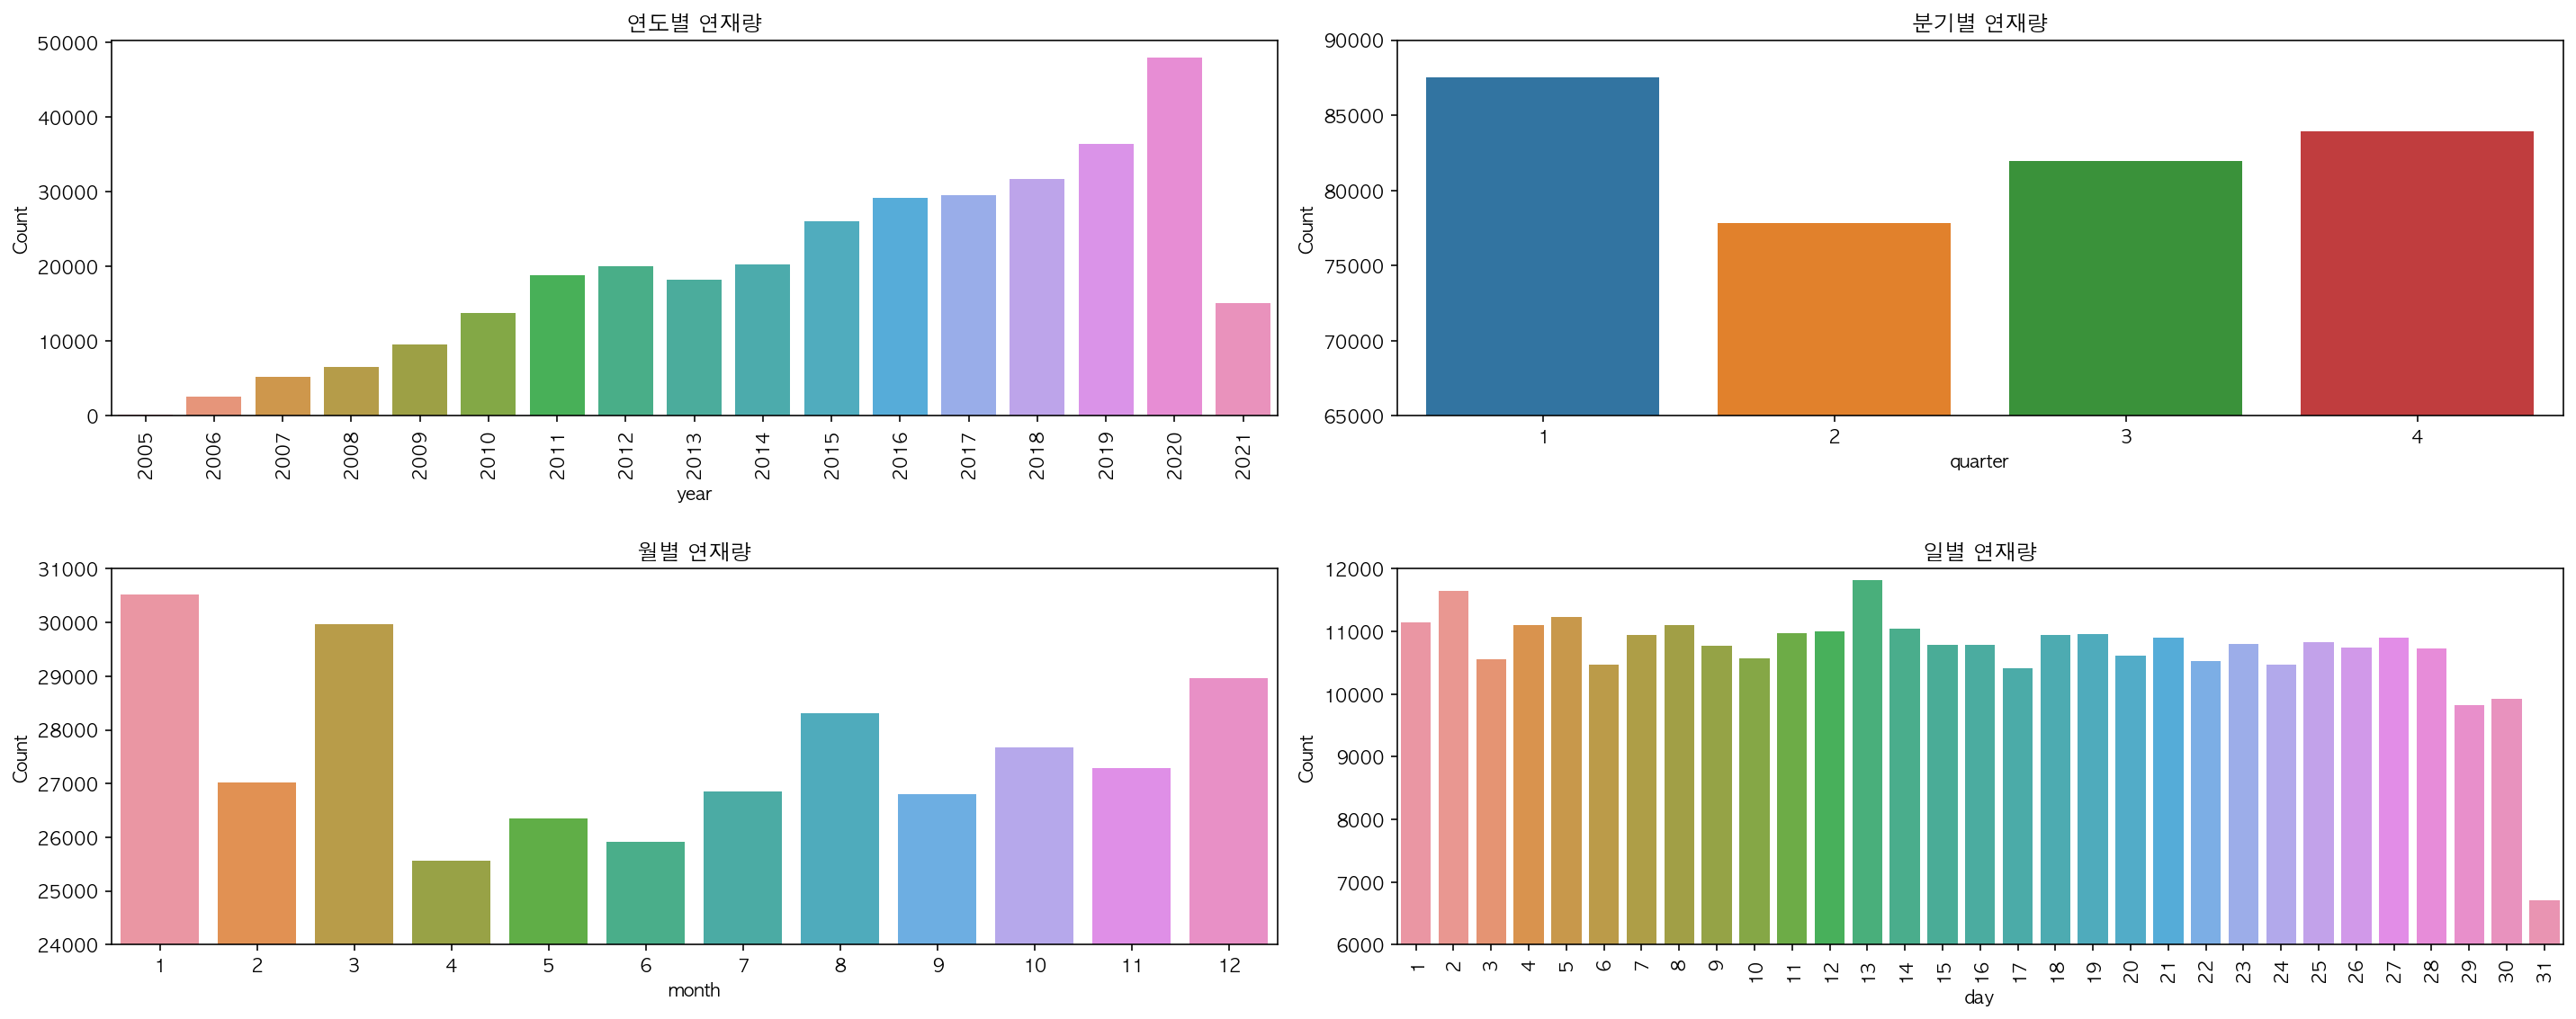

In [45]:
result_year = yearly_df.groupby('year').size().reset_index(name='count')
result_quarter = yearly_df.groupby('quarter').size().reset_index(name='count')
result_mon = yearly_df.groupby('month').size().reset_index(name='count')
result_day = yearly_df.groupby('day').size().reset_index(name='count')

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(20, 8))

sns.barplot(data=result_year, x='year', y='count', ax=ax1)
sns.barplot(data=result_quarter, x='quarter', y='count', ax=ax2)
sns.barplot(data=result_mon, x='month', y='count', ax=ax3)
sns.barplot(data=result_day, x='day', y='count', ax=ax4)

ax1.set(ylabel='Count', title='연도별 연재량')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)
ax2.set(ylabel='Count', title='분기별 연재량', ylim=(65000, 90000))
ax3.set(ylabel='Count', title='월별 연재량', ylim=(24000, 31000))
ax4.set(ylabel='Count', title='일별 연재량', ylim=(6000, 12000))
ax4.set_xticklabels(ax4.get_xticklabels(), rotation=90)

plt.tight_layout(h_pad=2)
plt.show()

-> 1, 3월에 웹툰 연재량이 많고, 4~7월달에 연재량이 적은 것을 알 수 있다.

-> 일별 연재량은 고른 편이고 31일은 격월로 있기에 비교적 적은 것을 알 수 있다.

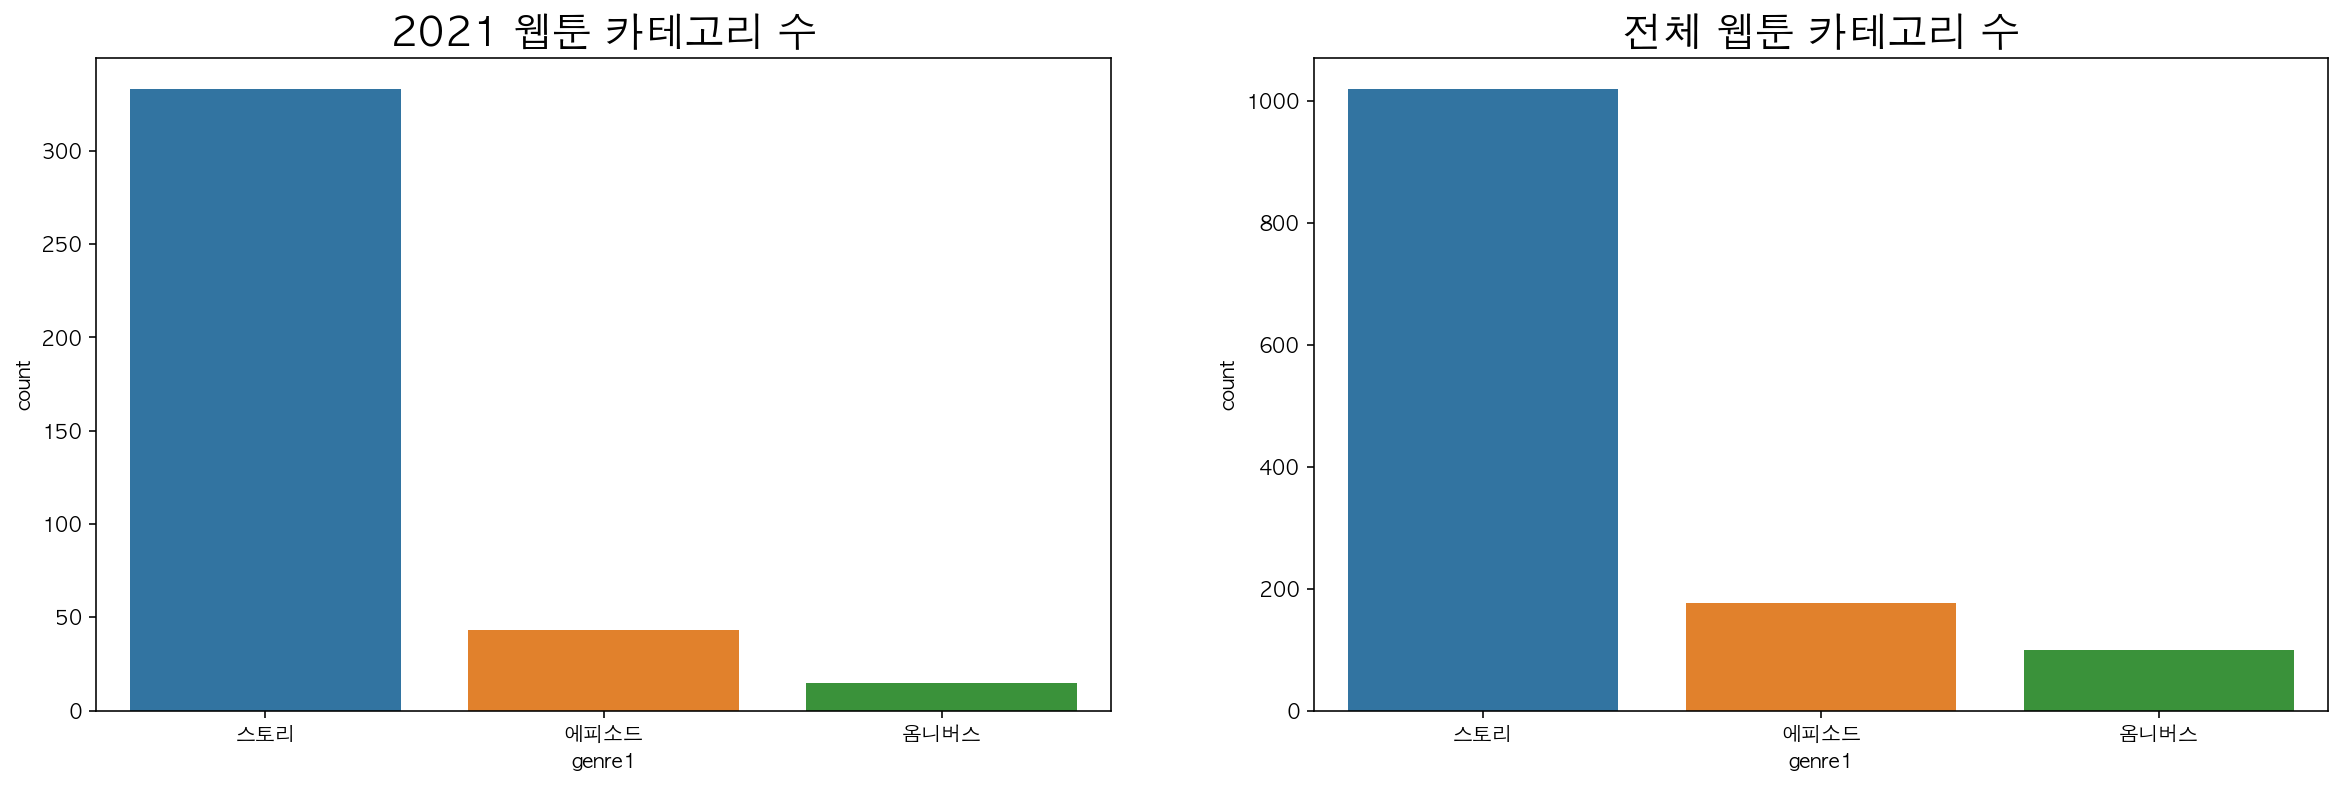

In [46]:
result1 = yearly_df.groupby(['title', 'genre1']).size().groupby('genre1').size().reset_index(name='count')
result2 = yearly_df.groupby(['title', 'genre2']).size().groupby('genre2').size().reset_index(name='count')
result2.sort_values('count', ascending=False, inplace=True)

plt.figure(figsize=(20, 6))

plt.subplot(121)
sns.barplot(data=cate_1, x='genre1', y='count')
plt.title('2021 웹툰 카테고리 수', fontsize=20)

plt.subplot(122)
sns.barplot(data=result1, x='genre1', y='count')
plt.title('전체 웹툰 카테고리 수', fontsize=20)

plt.show()

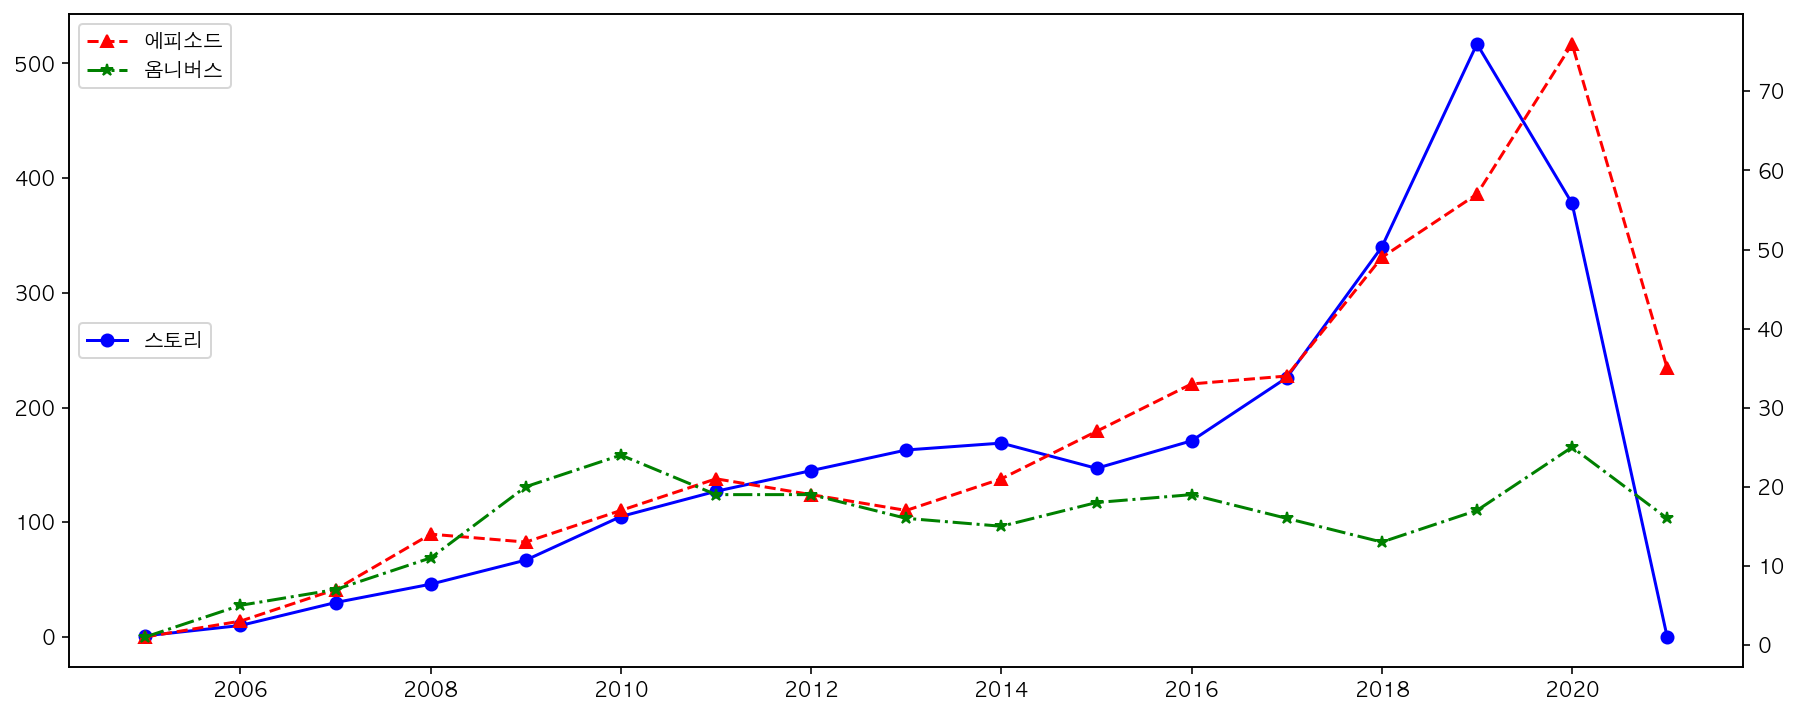

In [47]:
result = yearly_df.groupby(['cate_year', 'title', 'genre1']).size().groupby(['cate_year', 'genre1']).size().reset_index(name='count')
result = result.append({'cate_year': 2005, 'genre1': '스토리', 'count': 0}, ignore_index=True)

x = result['cate_year'].unique()
y1 = result[result['genre1'] == "스토리"]['count']
y2 = result[result['genre1'] == "에피소드"]['count']
y3 = result[result['genre1'] == "옴니버스"]['count']

fig, ax1 = plt.subplots(1, 1, figsize=(15, 6))

ax1.plot(x, y1, "bo-", label="스토리")
ax1.legend(loc='center left')
ax_tmp = ax1.twinx()
ax_tmp.plot(x, y2, "^--", label="에피소드", color='r')
ax_tmp.plot(x, y3, "*-.", label="옴니버스", color='g')

plt.legend()
plt.show()

-> 스토리와 에피소드 카테고리는 증가하는 추세지만 옴니버스는 일정하다.

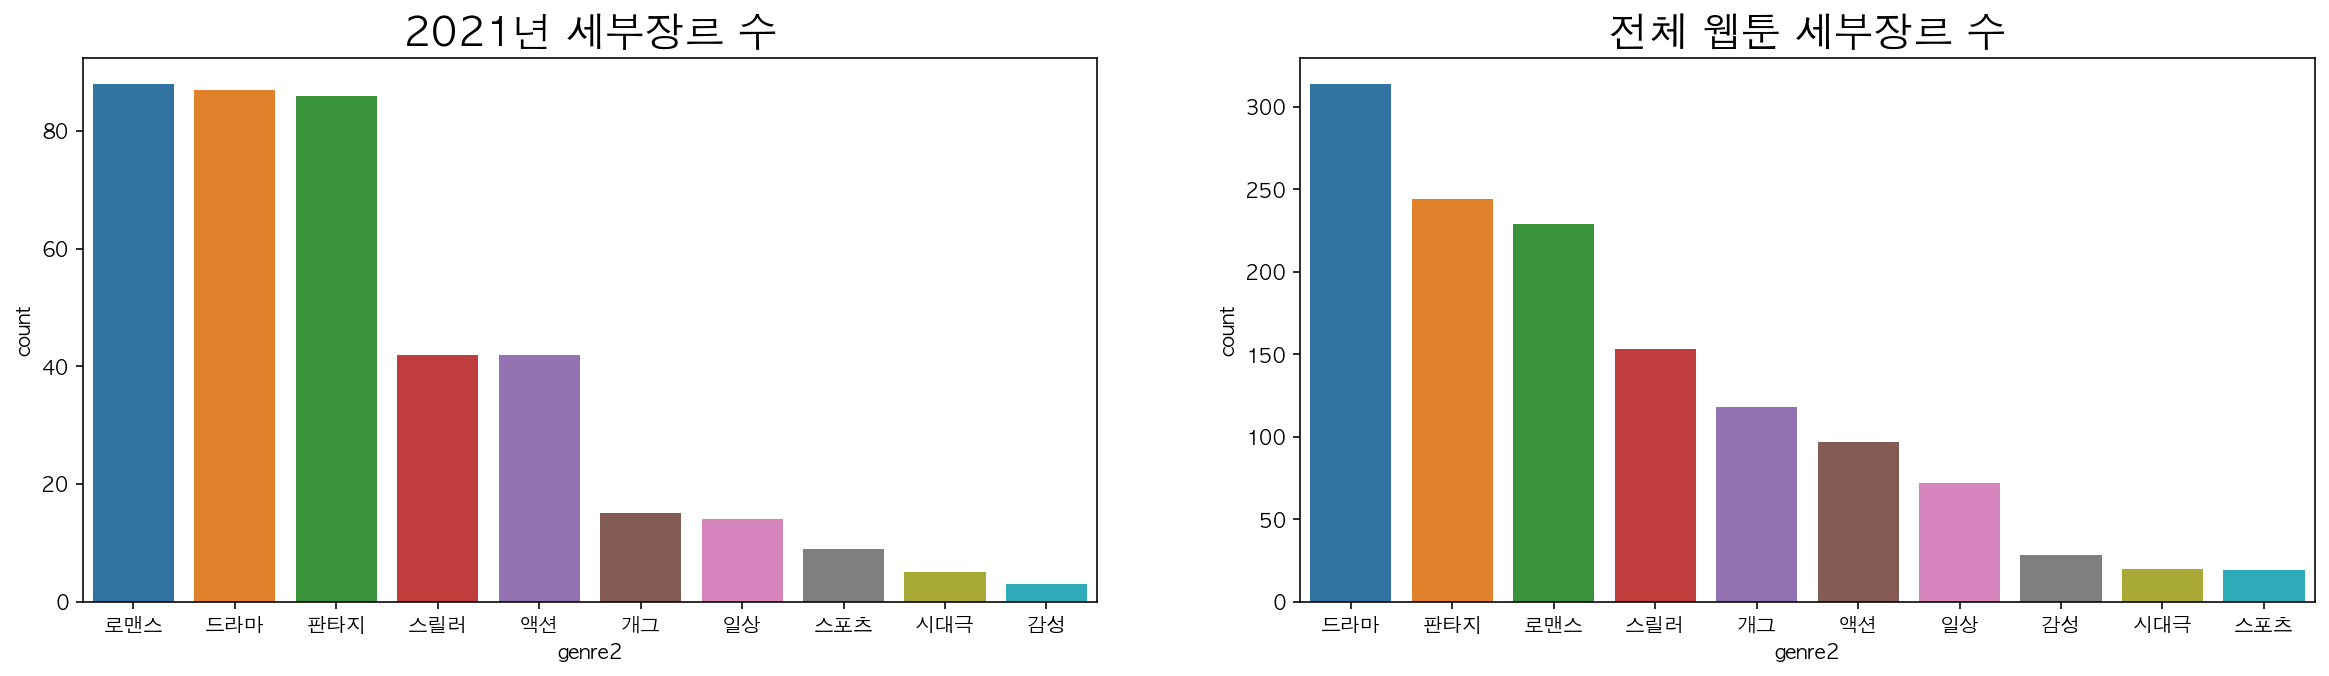

In [48]:
plt.figure(figsize=(20, 5))

plt.subplot(121)
sns.barplot(data=cate_2, x='genre2', y='count', )
plt.title('2021년 세부장르 수', fontsize=20)

plt.subplot(122)
sns.barplot(data=result2, x='genre2', y='count')
plt.title('전체 웹툰 세부장르 수', fontsize=20)

plt.show()

-> 2021년에 로맨스와 판타지 장르의 웹툰이 많이 연재된다고 볼 수 있다.

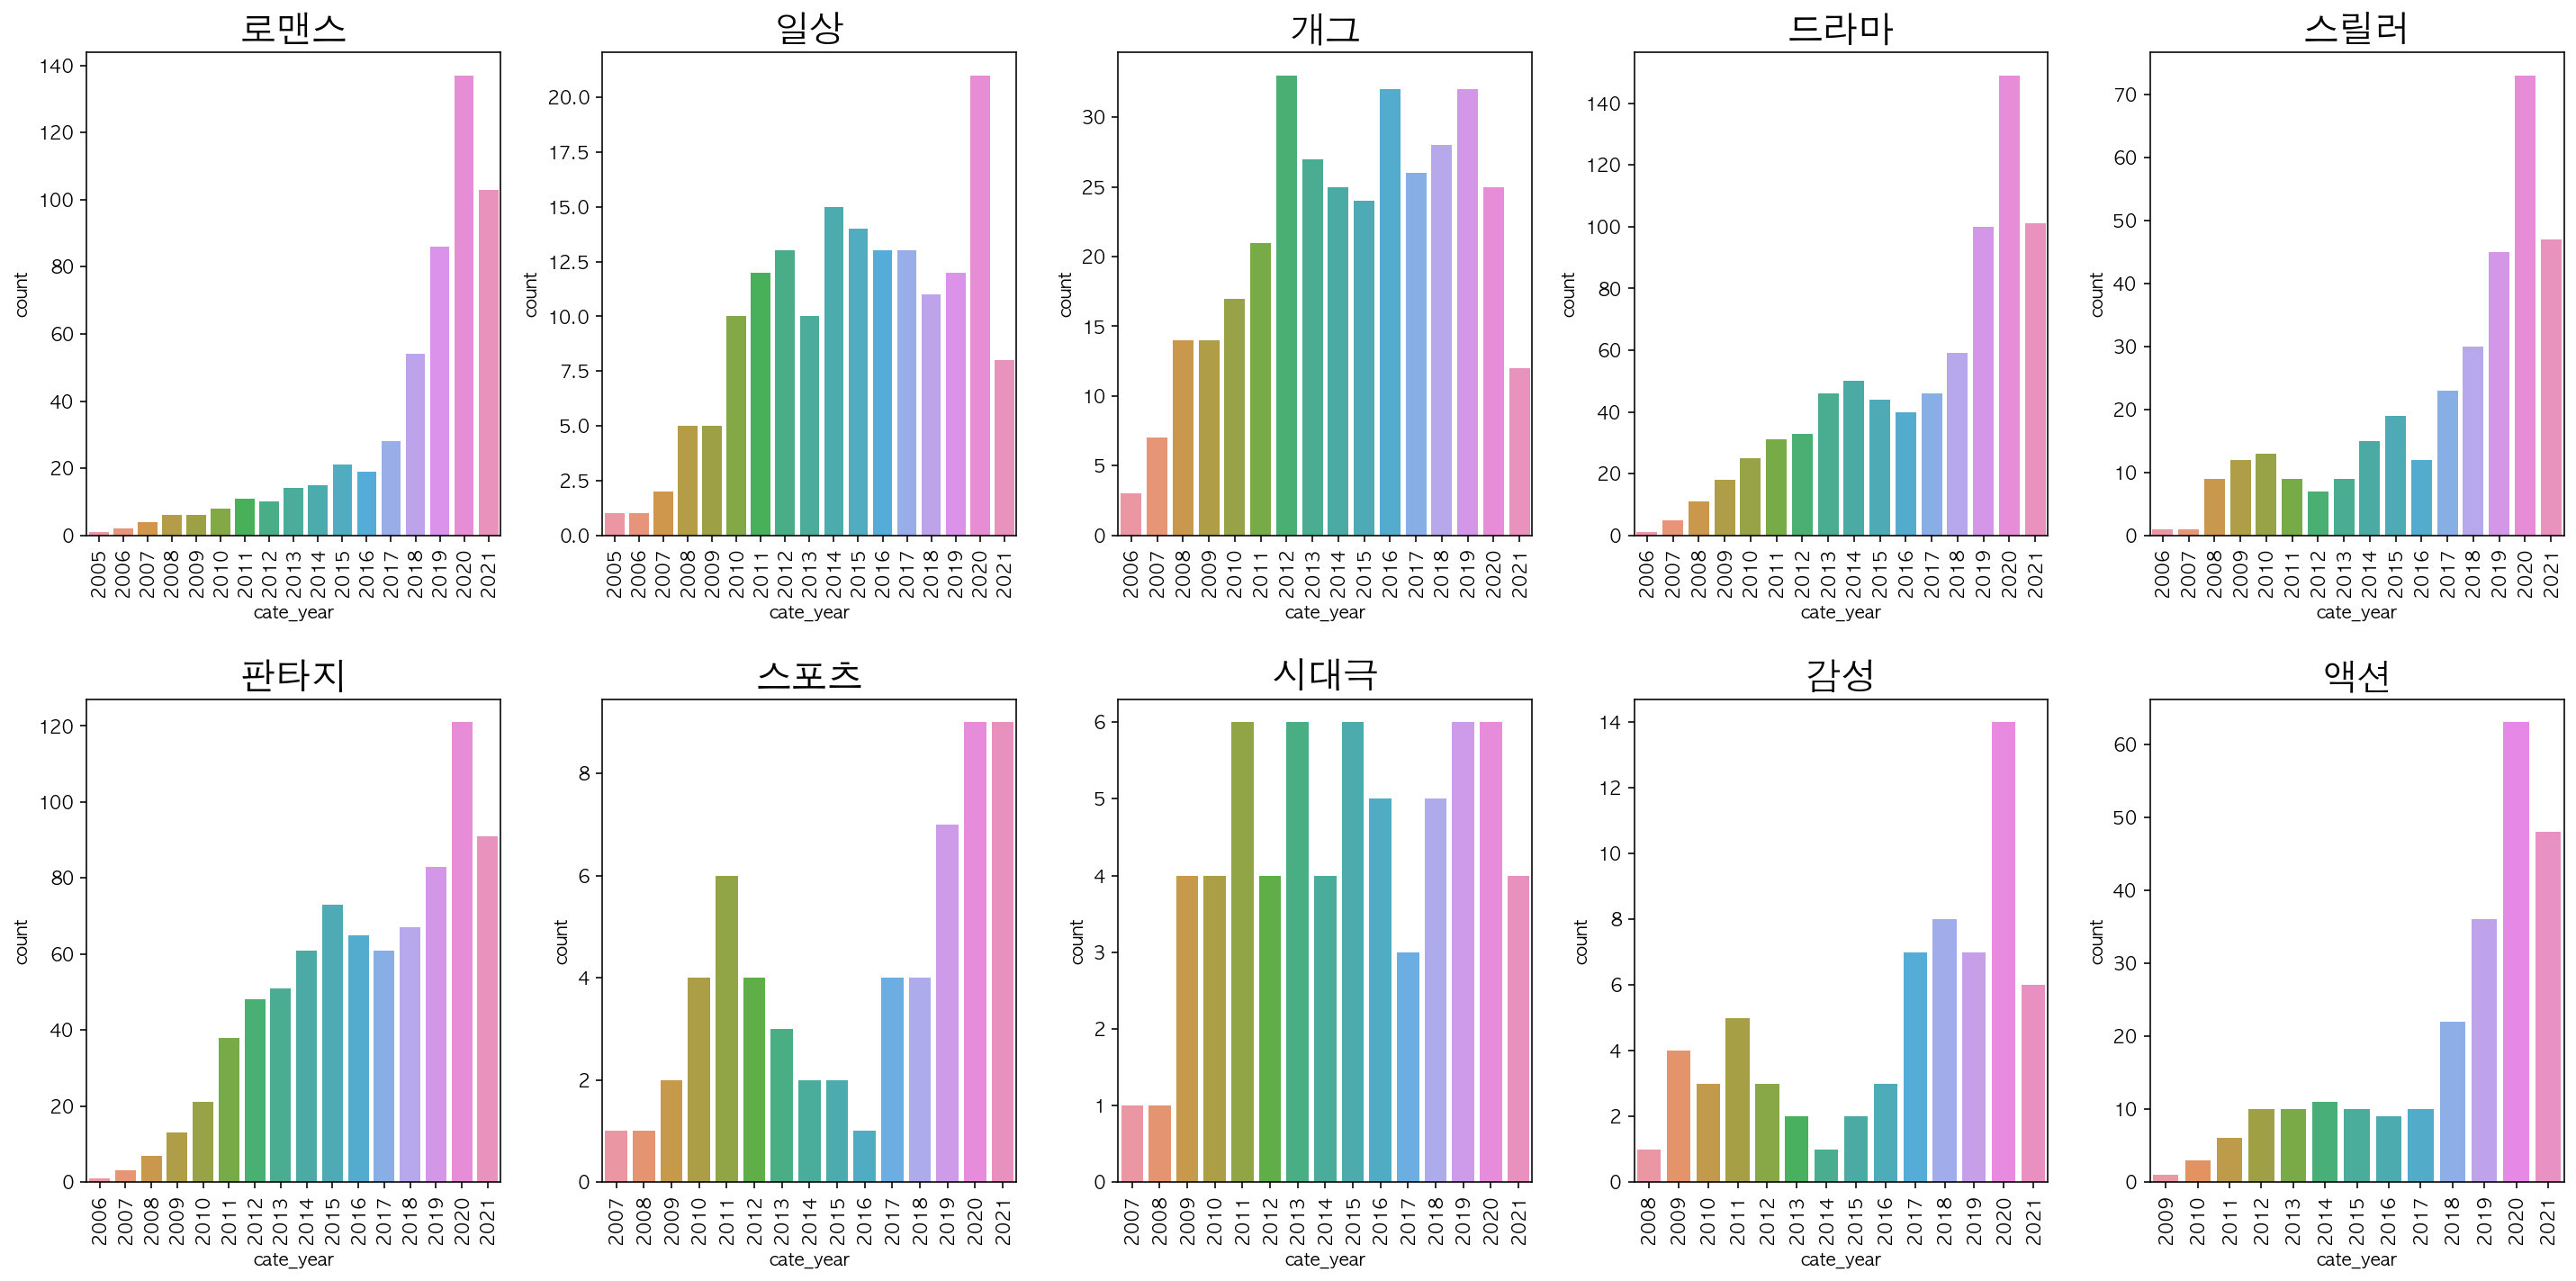

In [58]:
result = yearly_df.groupby(['cate_year', 'title', 'genre2']).size().groupby(['cate_year', 'genre2']).size().reset_index(name='count')

plt.figure(figsize=(20, 10))

N, M = 2, 5
for n in range(N*M):
    plt.subplot(N, M, n+1)
    sns.barplot(data=result[result['genre2'] == result['genre2'].unique()[n]], x='cate_year', y='count')
    plt.xticks(rotation=90)
    plt.title(result['genre2'].unique()[n], fontsize=20)
    
plt.tight_layout(h_pad=2)

-> 개그, 시대극 장르는 다른 장르에 비해 인기가 없다고 할 수 있다.

-> 로맨스, 드라마, 스릴러, 판타지, 액션 장르는 높은 증가 추세를 보이고 있다.

### 가설 2. 평점이 낮은 회차는 분량과 참여도가 낮을 것이다

#### 평점과 분량과 참여도간의 상관관계 분석
- img : 0, 1인 웹툰 삭제
    - 331255 -> 313467 : 17788 row 손실

In [59]:
result = yearly_df[yearly_df['img'] != 0]
result = yearly_df[yearly_df['img'] != 1]

print("before : {} -> after : {}".format(yearly_df.shape[0] ,result.shape[0]))

before : 331255 -> after : 313467


#### 웹툰별 세 개의 평가지표간 상관관계 dataframe 생성
- star_img : 평점과 분량간 상관관계
- star_person : 평점과 참여도간 상관관계
- img_person : 분량과 참여도간 상관관계

In [195]:
corr_df = pd.DataFrame(columns=['genre1', 'genre2', 'title', 'star_img', 'star_person', 'img_person'])
corr_df

,genre1,genre2,title,star_img,star_person,img_person


In [197]:
for idx in range(len(result['title'].unique())):
    data = result[result['title'] == result['title'].unique()[idx]][['star', 'img', 'person']]
    data_corr = data.corr().round(4) # 상관관계
    
    title = result['title'].unique()[idx]
    genre1 = result[result['title'] == result['title'].unique()[idx]]['genre1'].unique()[0]
    genre2 = result[result['title'] == result['title'].unique()[idx]]['genre2'].unique()[0]
    star_img = data_corr.iloc[0, 1]
    star_person = data_corr.iloc[0, 2]
    img_person = data_corr.iloc[1, 2]
    
    row = {
        'genre1': genre1,
        'genre2': genre2,
        'title': title,
        'star_img': star_img,
        'star_person': star_person,
        'img_person': img_person
    }
    
    corr_df.loc[len(corr_df)] = row

corr_df.head()

,genre1,genre2,title,star_img,star_person,img_person
0,에피소드,일상,골방환상곡,-0.3151,-0.0932,0.4531
1,옴니버스,로맨스,사랑in,0.3379,-0.3124,0.3580
2,에피소드,개그,마음의소리,-0.5535,-0.9196,0.4708
3,옴니버스,스릴러,수사9단,0.8983,-0.8009,-0.9808
4,에피소드,개그,와탕카,NaN,NaN,NaN


#### NaN 데이터 제거

In [213]:
corr_df = corr_df[np.all(corr_df.notnull(), axis=1)]
corr_df.head()

,genre1,genre2,title,star_img,star_person,img_person
0,에피소드,일상,골방환상곡,-0.3151,-0.0932,0.4531
1,옴니버스,로맨스,사랑in,0.3379,-0.3124,0.3580
2,에피소드,개그,마음의소리,-0.5535,-0.9196,0.4708
3,옴니버스,스릴러,수사9단,0.8983,-0.8009,-0.9808
5,옴니버스,개그,입시명문사립 정...,0.2181,-0.3423,0.0688


전 웹툰의 평균 star_person : -0.4013


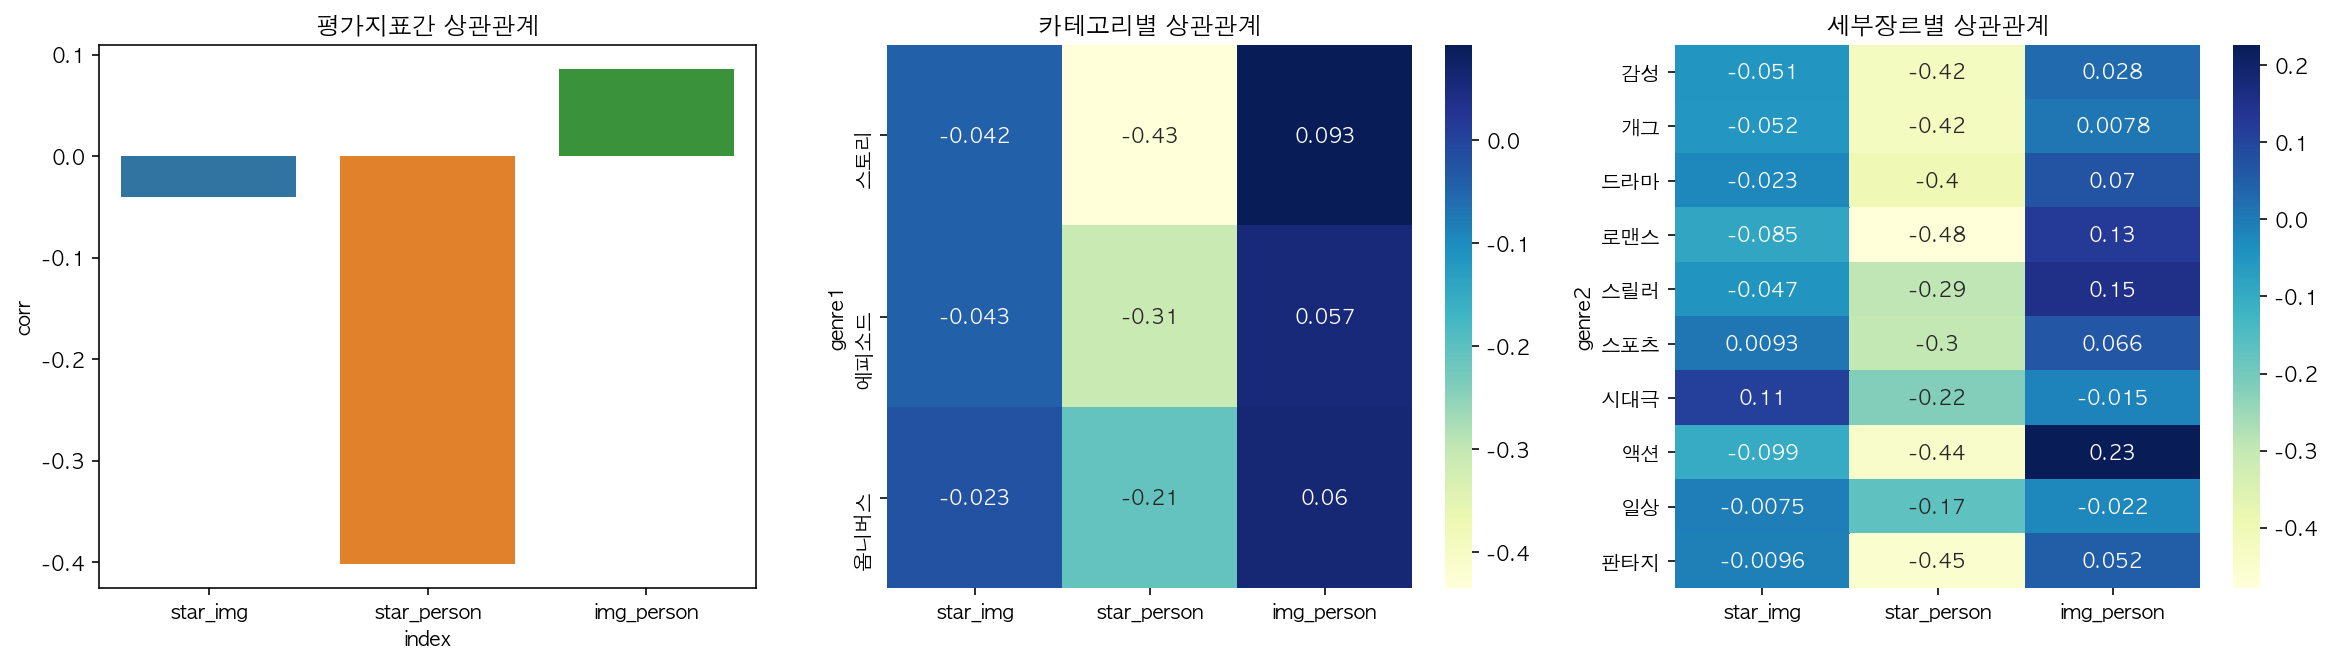

In [218]:
# 전체 웹툰의 평점, 분량, 참여도 간의 상관관계
result = corr_df.mean().reset_index(name='corr')
print('전 웹툰의 평균 star_person : {}'.format(result.loc[1]['corr'].round(4)))

plt.figure(figsize=(20, 5))

plt.subplot(131)
sns.barplot(data=result, x='index', y='corr')
plt.title('평가지표간 상관관계')

plt.subplot(132)
sns.heatmap(corr_df.groupby('genre1').agg('mean'), annot=True, cmap="YlGnBu")
plt.title('카테고리별 상관관계')

plt.subplot(133)
sns.heatmap(corr_df.groupby('genre2').agg('mean'), annot=True, cmap="YlGnBu")
plt.title('세부장르별 상관관계')

plt.show()

-> 각 웹툰간 상관관계의 평균을 통해 star_person : -0.4013으로 평균과 참여도간 약한 음의 상관관계를 가진다는 것을 알 수 있다.

-> 또한 카테고리별, 세부장르별 상관관계에서도 평점과 참여도간 약한 음의 상관관계를 보인다.

#### 평점이 낮은 회차와 아닌 회차의 분류
- 상관관계 외에 시각적인 차이를 파악하기 위해
- lower : 각 웹툰의 평점에서 1분위수보다 작은 회차
- normal : 강 웹툰의 평점에서 1분위수 이상인 회차

In [49]:
yearly_df["low_star"] = \
yearly_df.apply(lambda x: "lower" if x['star'] < np.percentile(yearly_df[yearly_df['title'] == x['title']]['star'], 25) else "normal", axis=1)

In [38]:
yearly_df.tail()

,cate_year,title,genre,genre1,genre2,star,img,person,datetime,year,quarter,month,day,low_star
331250,2021,9등급 뒤집기,스토리 드라마,스토리,드라마,9.67,44,4916,2020-01-16,2020,1,1,16,normal
331251,2021,9등급 뒤집기,스토리 드라마,스토리,드라마,9.68,40,3802,2020-01-09,2020,1,1,9,normal
331252,2021,9등급 뒤집기,스토리 드라마,스토리,드라마,9.53,46,5076,2020-01-02,2020,1,1,2,normal
331253,2021,9등급 뒤집기,스토리 드라마,스토리,드라마,8.89,64,7815,2019-12-26,2019,4,12,26,normal
331254,2021,9등급 뒤집기,스토리 드라마,스토리,드라마,5.94,89,12699,2019-12-19,2019,4,12,19,lower


In [189]:
# with open('data/yearly_lowstar_df.pkl', 'wb') as f:
#     pickle.dump(yearly_df, f)

with open('data/yearly_lowstar_df.pkl', 'rb') as f:
    yearly_df = pickle.load(f)

#### 모든 star, img, person에 대한 분포

In [190]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler


all_ss_star = StandardScaler().fit_transform(np.array(yearly_df['star']).reshape(-1, 1))
all_mm_star = MinMaxScaler().fit_transform(np.array(yearly_df['star']).reshape(-1, 1))

yearly_df['all_ss_star'] = all_ss_star
yearly_df['all_mm_star'] = all_mm_star

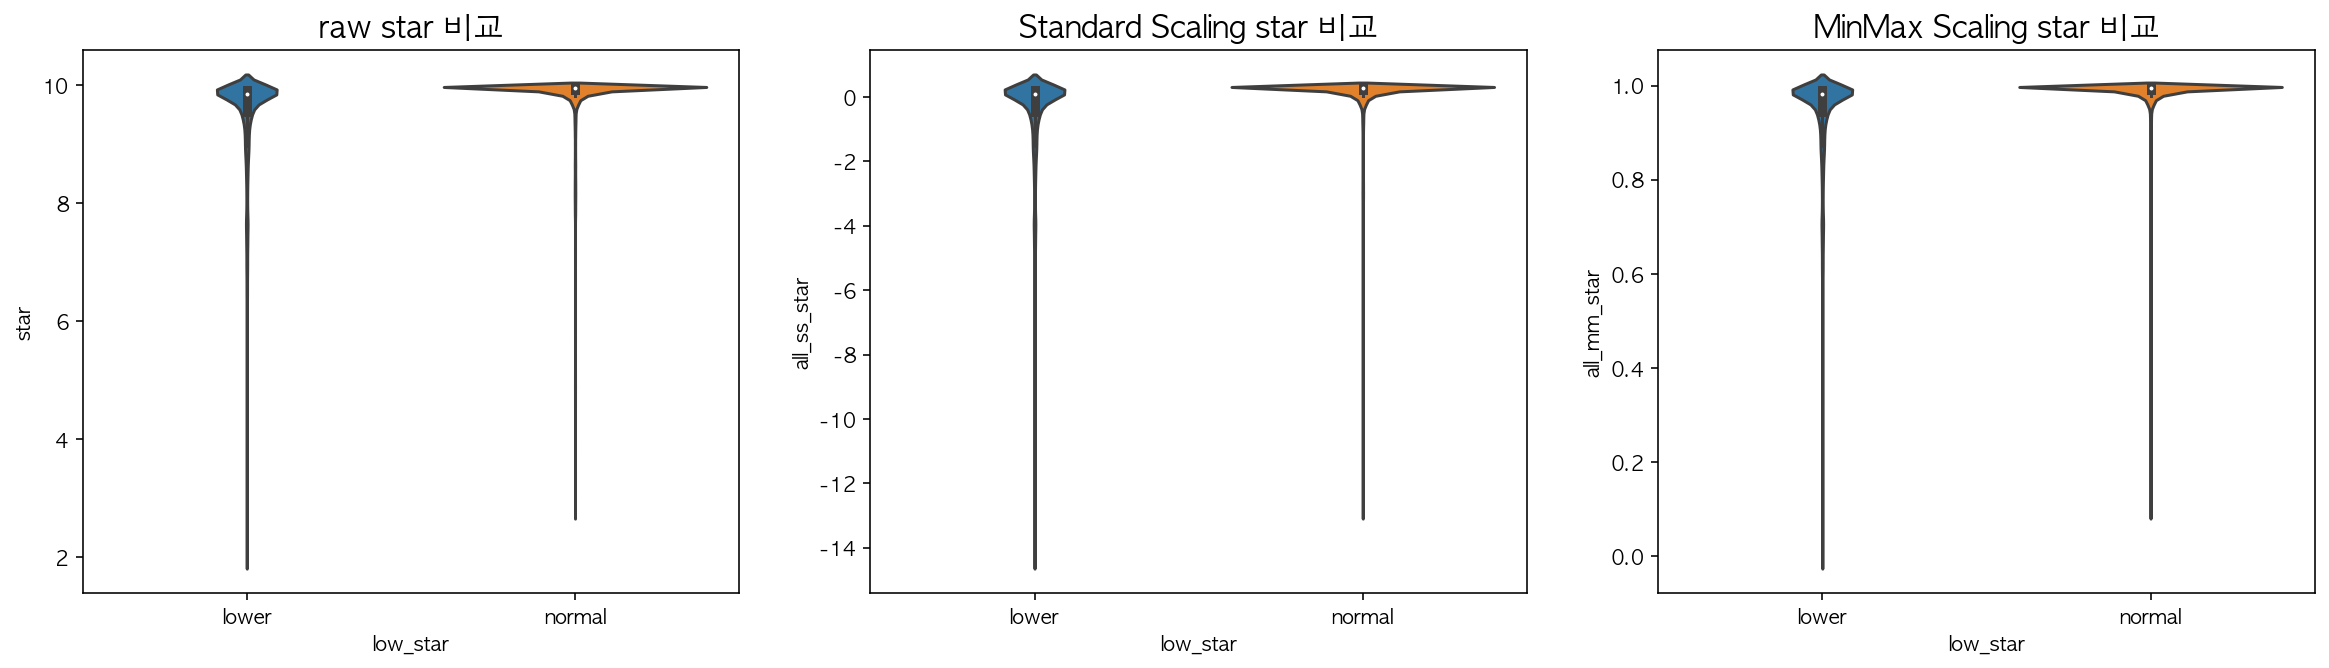

In [191]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))

sns.violinplot(data=yearly_df, x='low_star', y='star', ax=ax[0])
sns.violinplot(data=yearly_df, x='low_star', y='all_ss_star', ax=ax[1])
sns.violinplot(data=yearly_df, x='low_star', y='all_mm_star', ax=ax[2])

ax[0].set_title('raw star 비교', fontsize=15)
ax[1].set_title('Standard Scaling star 비교', fontsize=15)
ax[2].set_title('MinMax Scaling star 비교', fontsize=15)

plt.show()

-> 기준 없이 scaling한 데이터의 violinplot은 기존 star의 분포와 눈에 띄는 차이를 파악하기 힘들다.

#### 각 웹툰별 star, img, person MinMaxScaling

In [194]:
def title_mm_star_scaler(row):
    raw_star = yearly_df[yearly_df['title'] == row['title']]['star']
    raw_star = (raw_star.values).reshape(-1,1)
    scaler = MinMaxScaler().fit(raw_star)
    row_star = np.array(row['star']).reshape(-1,1)
    
    return scaler.transform(row_star)

def title_mm_img_scaler(row):
    raw_img = yearly_df[yearly_df['title'] == row['title']]['img']
    raw_img = (raw_img.values).reshape(-1, 1)
    scaler = MinMaxScaler().fit(raw_img)
    row_img = np.array(row['img']).reshape(-1, 1)
    
    return scaler.transform(row_img)

def title_mm_person_scaler(row):
    raw_person = yearly_df[yearly_df['title'] == row['title']]['person']
    raw_person = (raw_person.values).reshape(-1, 1)
    scaler = MinMaxScaler().fit(raw_person)
    row_person = np.array(row['person']).reshape(-1, 1)
    
    return scaler.transform(row_person)

#### star, img, person 컬럼에 MinMaxScaling

In [ ]:
yearly_df['mm_star'] = yearly_df.apply(title_mm_star_scaler, axis=1)
yearly_df['mm_img'] = yearly_df.apply(title_mm_star_scaler, axis=1)
yearly_df['mm_person'] = yearly_df.apply(title_mm_star_scaler, axis=1)

yearly_df['mm_star'] = yearly_df['mm_star'].astype('float')
yearly_df['mm_img'] = yearly_df['mm_img'].astype('float')
yearly_df['mm_person'] = yearly_df['mm_person'].astype('float')

yearly_df.drop(columns=['all_ss_star', 'all_mm_star'], axis=1, inplace=True)

In [196]:
# with open('data/yearly_mm_scaled.pkl', 'wb') as f:
#     pickle.dump(result, f)

with open('data/yearly_mm_scaled.pkl', 'rb') as f:
    yearly_df = pickle.load(f)

In [198]:
yearly_df.tail()

,cate_year,title,genre,genre1,genre2,star,img,person,datetime,year,quarter,month,day,low_star,mm_star,mm_img,mm_person
331250,2021,9등급 뒤집기,스토리 드라마,스토리,드라마,9.67,44,4916,2020-01-16,2020,1,1,16,normal,0.963824,0.181818,0.193221
331251,2021,9등급 뒤집기,스토리 드라마,스토리,드라마,9.68,40,3802,2020-01-09,2020,1,1,9,normal,0.966408,0.109091,0.077744
331252,2021,9등급 뒤집기,스토리 드라마,스토리,드라마,9.53,46,5076,2020-01-02,2020,1,1,2,normal,0.927649,0.218182,0.209806
331253,2021,9등급 뒤집기,스토리 드라마,스토리,드라마,8.89,64,7815,2019-12-26,2019,4,12,26,normal,0.762274,0.545455,0.493729
331254,2021,9등급 뒤집기,스토리 드라마,스토리,드라마,5.94,89,12699,2019-12-19,2019,4,12,19,lower,0.000000,1.000000,1.000000


#### boxplot, distplot을 그려주는 함수생성

In [85]:
# raw_col과 scaled_col의 boxplot을 그려주는 함수생성
def make_boxplot(df, prev_col, scaled_col):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

    sns.boxplot(data=df, x='low_star', y=prev_col, ax=ax1)
    sns.boxplot(data=df, x='low_star', y=scaled_col, ax=ax2)

    ax1.set_title(f'{prev_col}', fontsize=15)
    ax2.set_title(f'{scaled_col}', fontsize=15)

    plt.show()

# lower, normal에 대한 distplot을 그려주는 함수생성
def make_distplot(col):
    low_mm_median = np.percentile(yearly_df[yearly_df['low_star'] == 'lower'][col], 50)
    low_mm_mean = np.mean(yearly_df[yearly_df['low_star'] == 'lower'][col])
    nor_mm_median = np.percentile(yearly_df[yearly_df['low_star'] == 'normal'][col], 50)
    nor_mm_mean = np.mean(yearly_df[yearly_df['low_star'] == 'normal'][col])
    print('lower median : {}, mean : {}'.format(low_mm_median.round(2), low_mm_mean.round(2)))
    print('normal median : {}, mean : {}'.format(nor_mm_median.round(2), nor_mm_mean.round(2)))
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

    sns.distplot(yearly_df[yearly_df['low_star'] == 'lower'][col], ax=ax1)
    ax1.axvline(x=low_mm_median, color='black', linestyle='--', linewidth='2', label="median")
    ax1.axvline(x=low_mm_mean, color='gray', linestyle='--', linewidth='2', label='mean')
    ax1.legend()

    sns.distplot(yearly_df[yearly_df['low_star'] == 'normal'][col], ax=ax2, color='r')
    ax2.axvline(x=nor_mm_median, color='black', linestyle='--', linewidth='2', label='median')
    ax2.axvline(x=nor_mm_mean, color='gray', linestyle='--', linewidth='2', label='mean')
    ax2.legend()

    ax1.set_title('1분위수 미만의 {}'.format(col), fontsize=15)
    ax2.set_title('1분위수 이상의 {}'.format(col), fontsize=15)

    plt.show()

#### raw star와 MinMax scaled star 비교

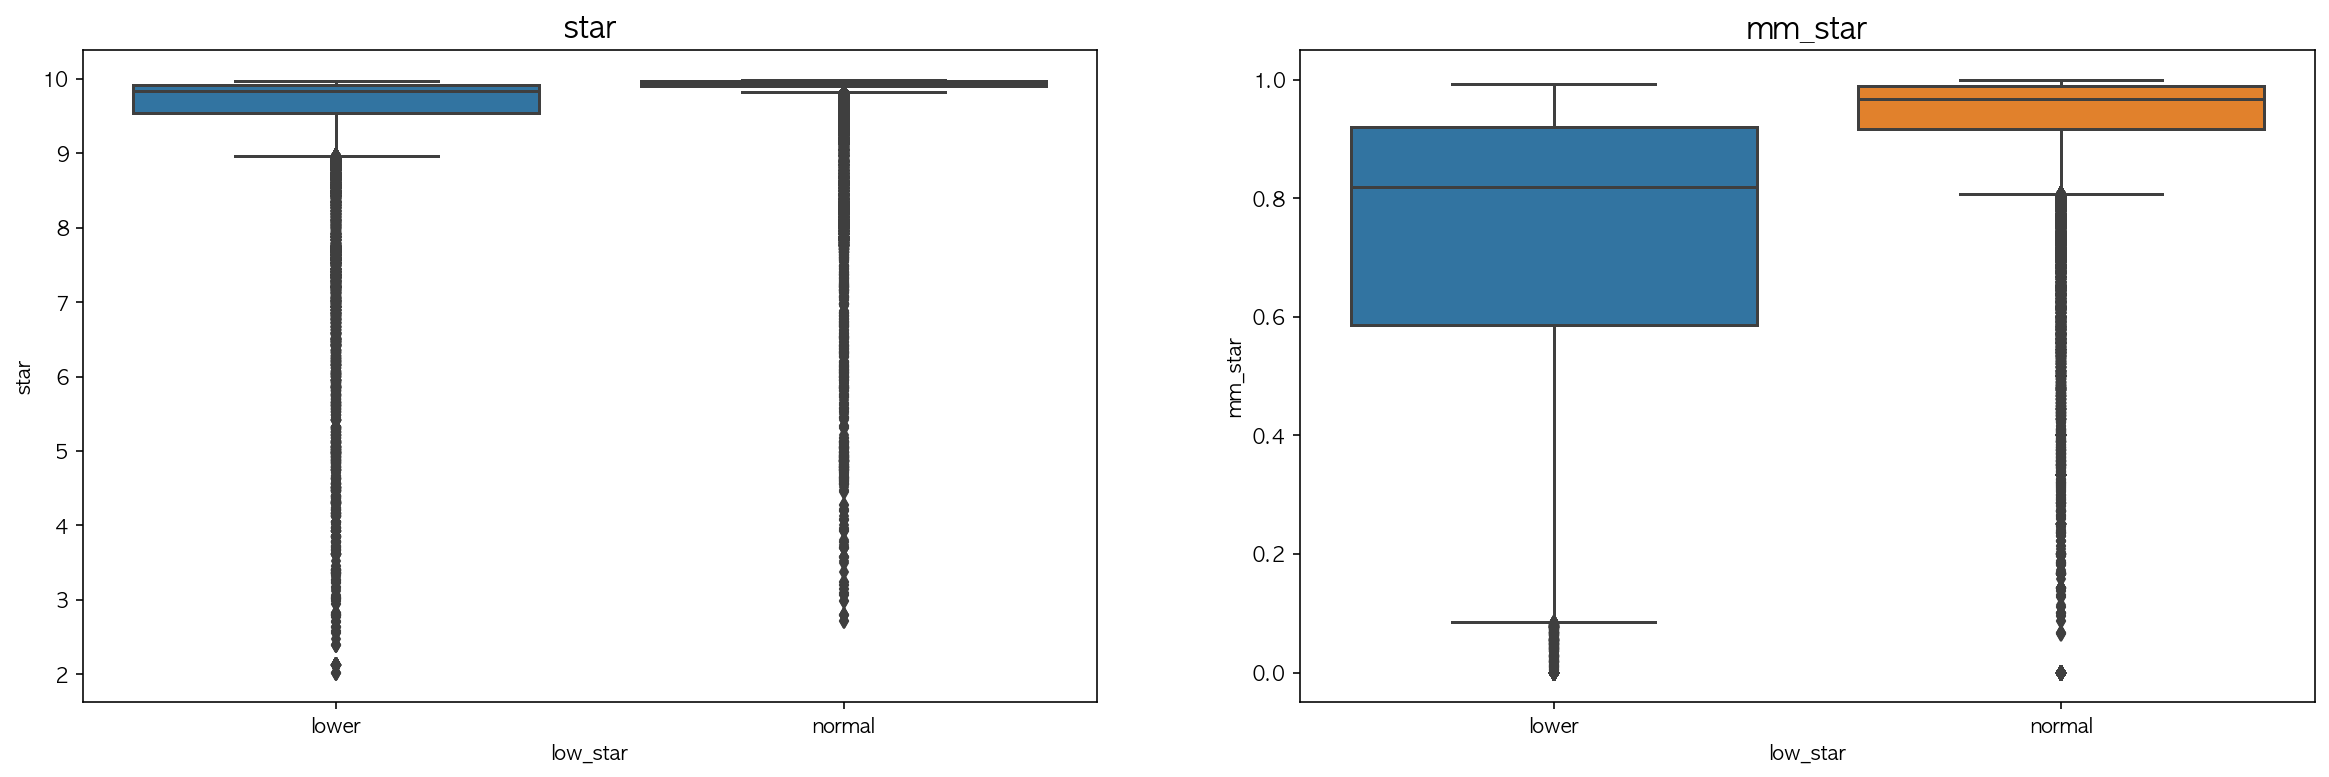

In [86]:
make_boxplot(yearly_df, 'star', 'mm_star')

lower median : 0.82, mean : 0.72
normal median : 0.97, mean : 0.93


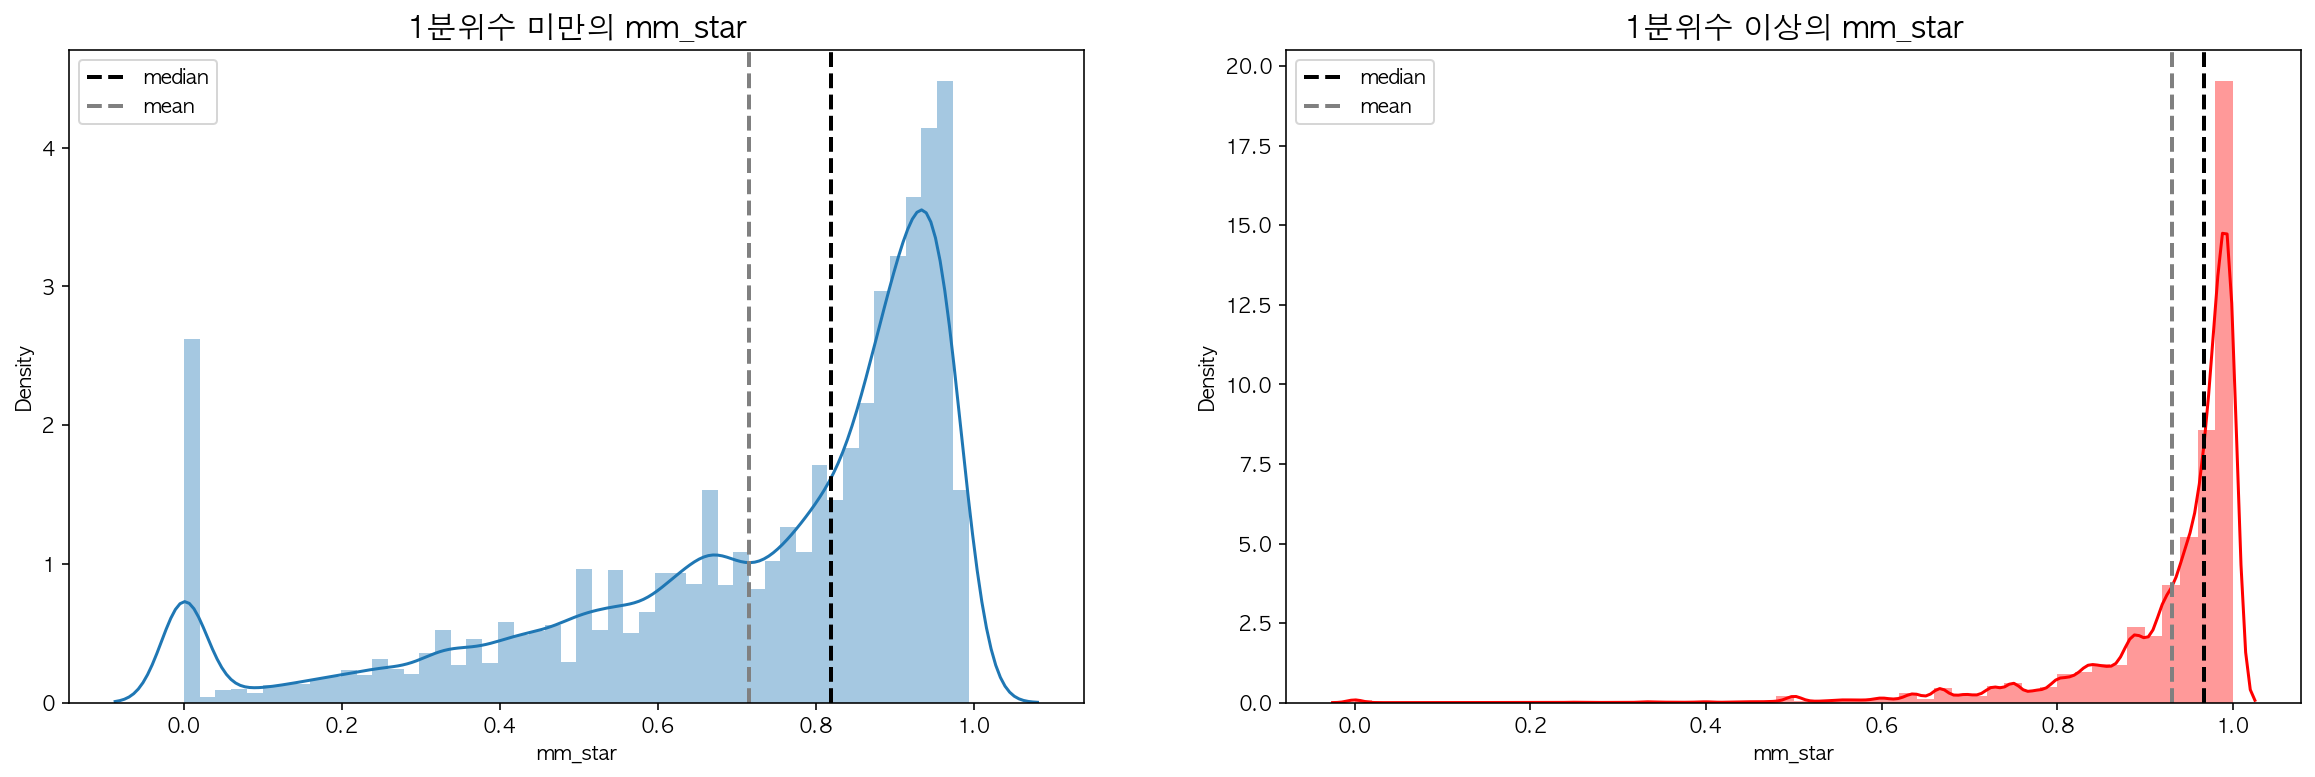

In [82]:
make_distplot('mm_star')

-> 1분위수보다 작은 회차의 분포에서 scaled_star가 0인 데이터가 많고, 1분위수 이상의 회차의 분포는 오른쪽으로 강하게 치우쳐져 있다.

#### raw img와 MinMax scaled img 비교 

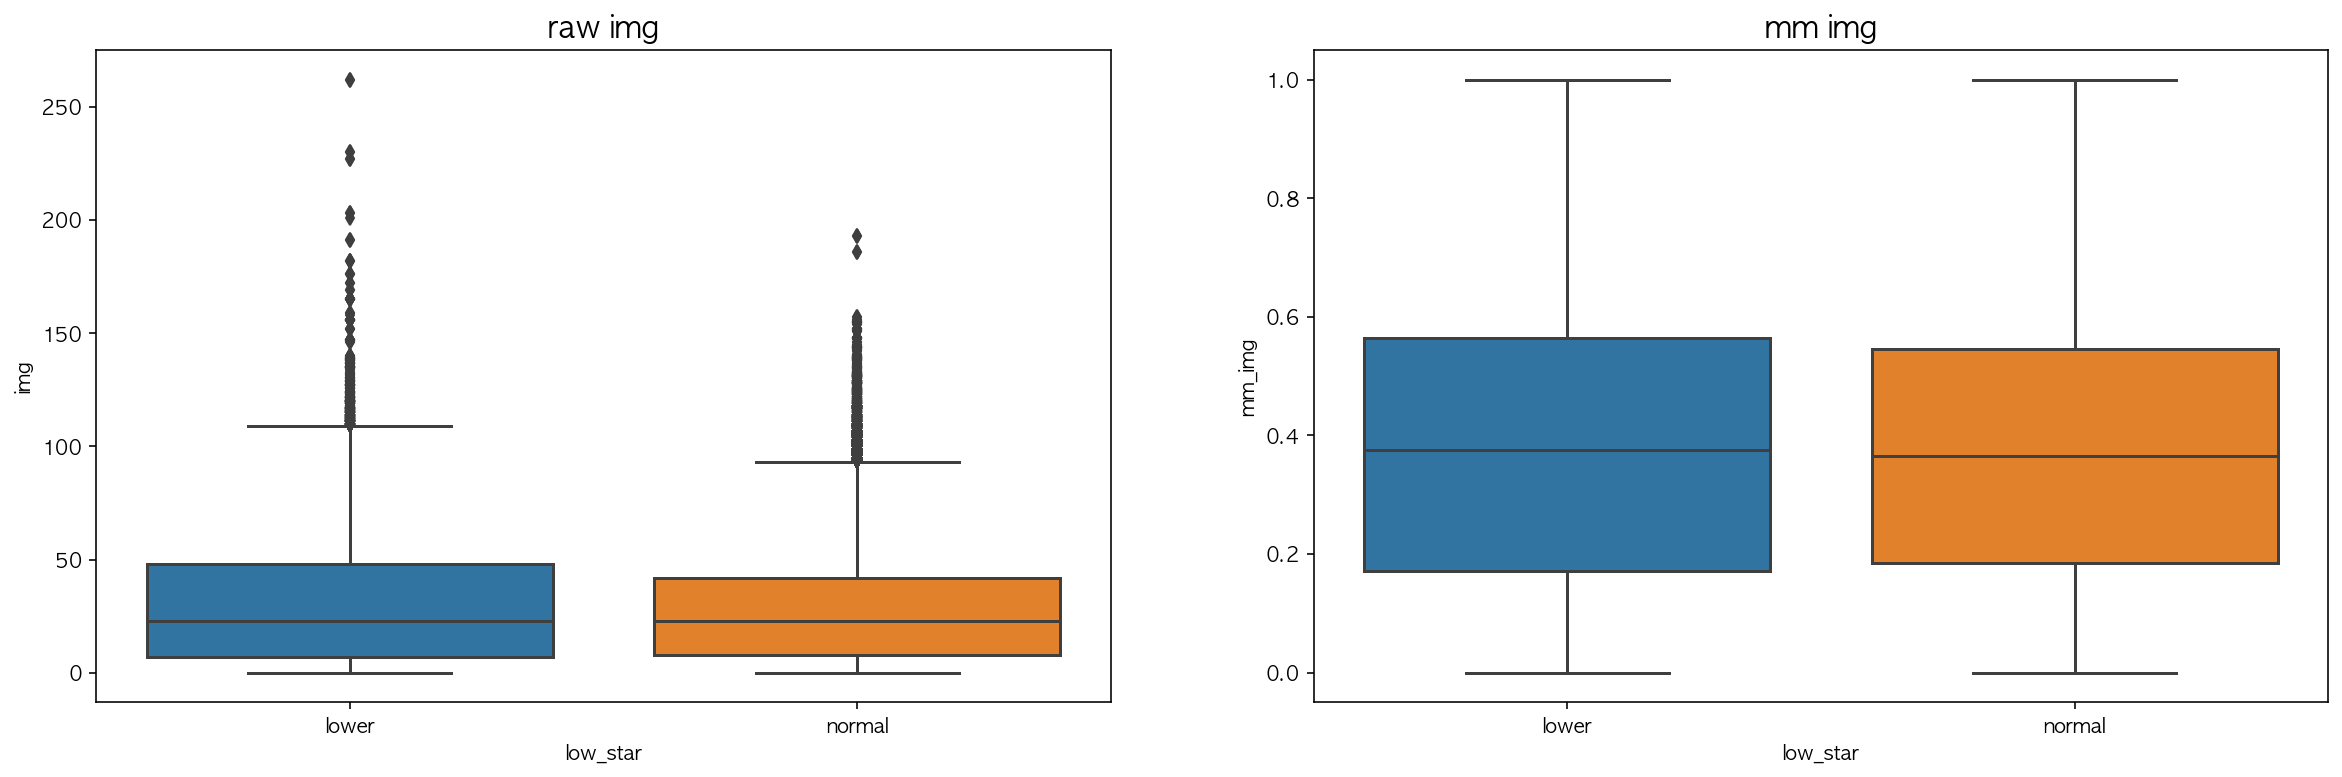

In [76]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

sns.boxplot(data=yearly_df, x='low_star', y='img', ax=ax1)
sns.boxplot(data=yearly_df, x='low_star', y='mm_img', ax=ax2)

ax1.set_title('raw img', fontsize=15)
ax2.set_title('mm img', fontsize=15)

plt.show()

lower median : 0.38, mean : 0.38
normal median : 0.37, mean : 0.37


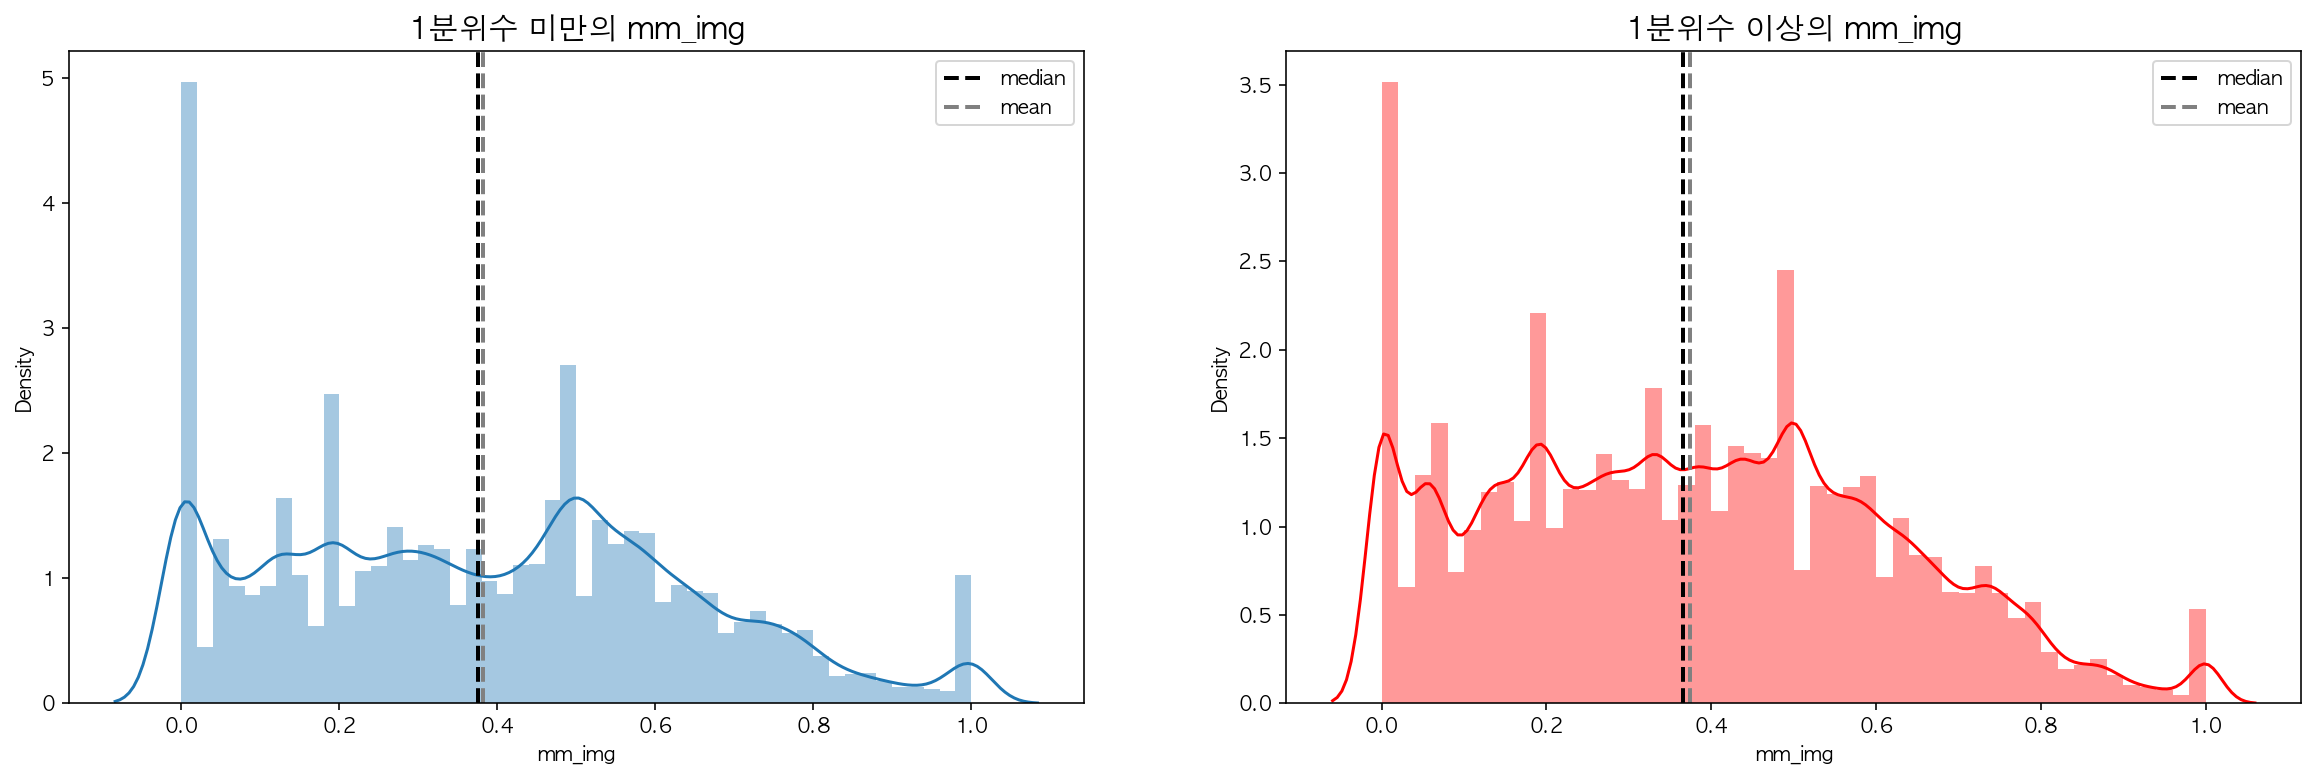

In [83]:
make_distplot('mm_img')

-> 분량에 대해서는 lower과 normal의 차이는 없다는 것을 알 수 있다.

#### raw person와 MinMax scaled person 비교 

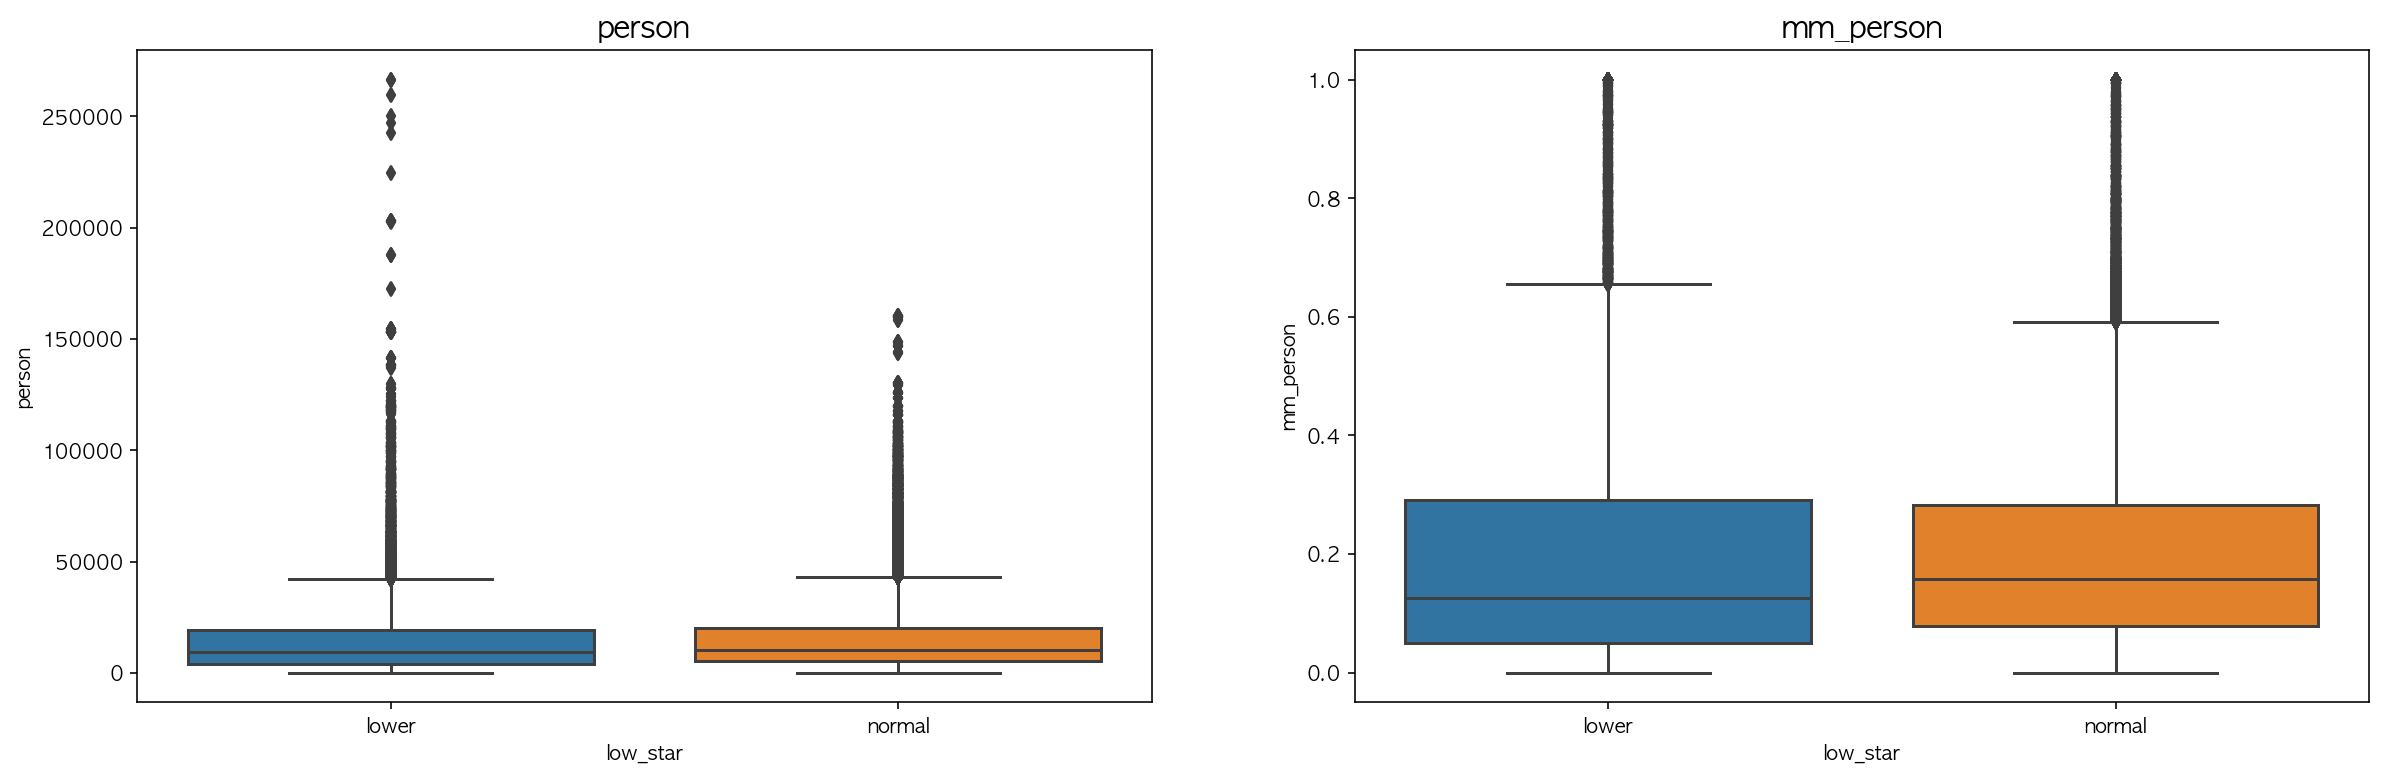

In [87]:
make_boxplot(yearly_df, 'person', 'mm_person')

lower median : 0.13, mean : 0.21
normal median : 0.16, mean : 0.2


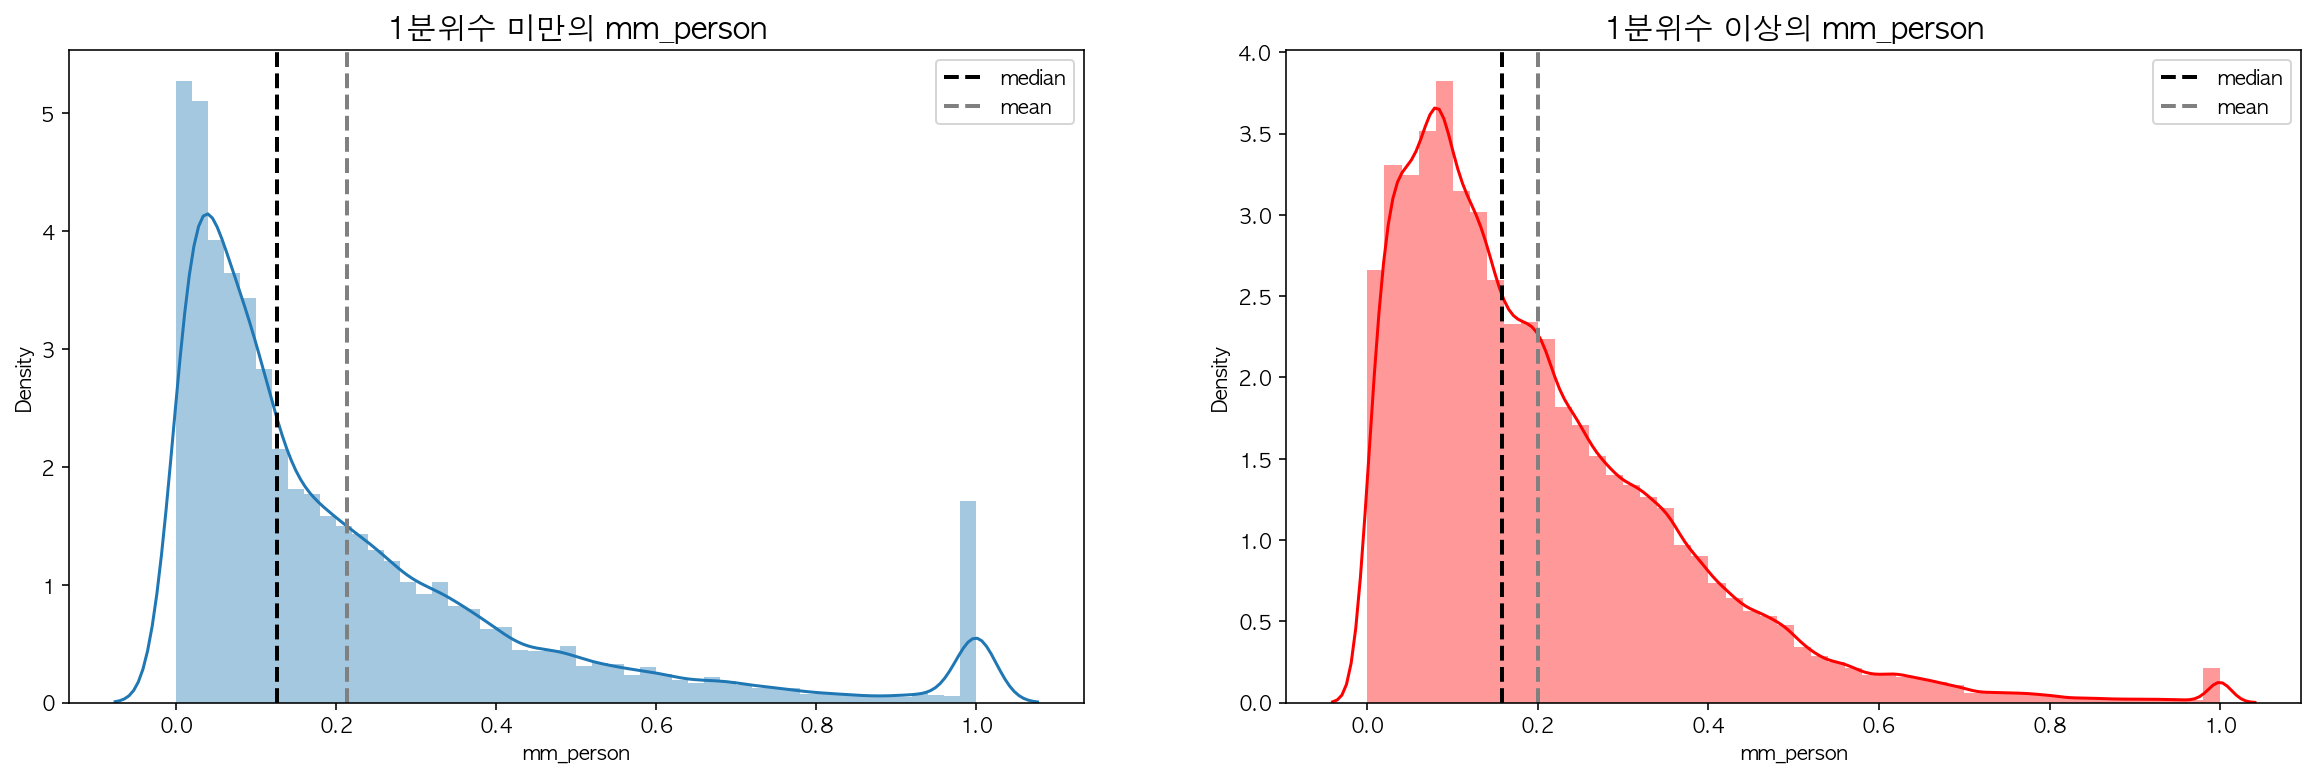

In [88]:
make_distplot('mm_person')

-> 참여도 분포도 lower와 normal이 차이가 없다는 것을 알 수 있다.

### 가설 3. 가을에 로맨스 장르의 웹툰이 인기가 많을 것이다.

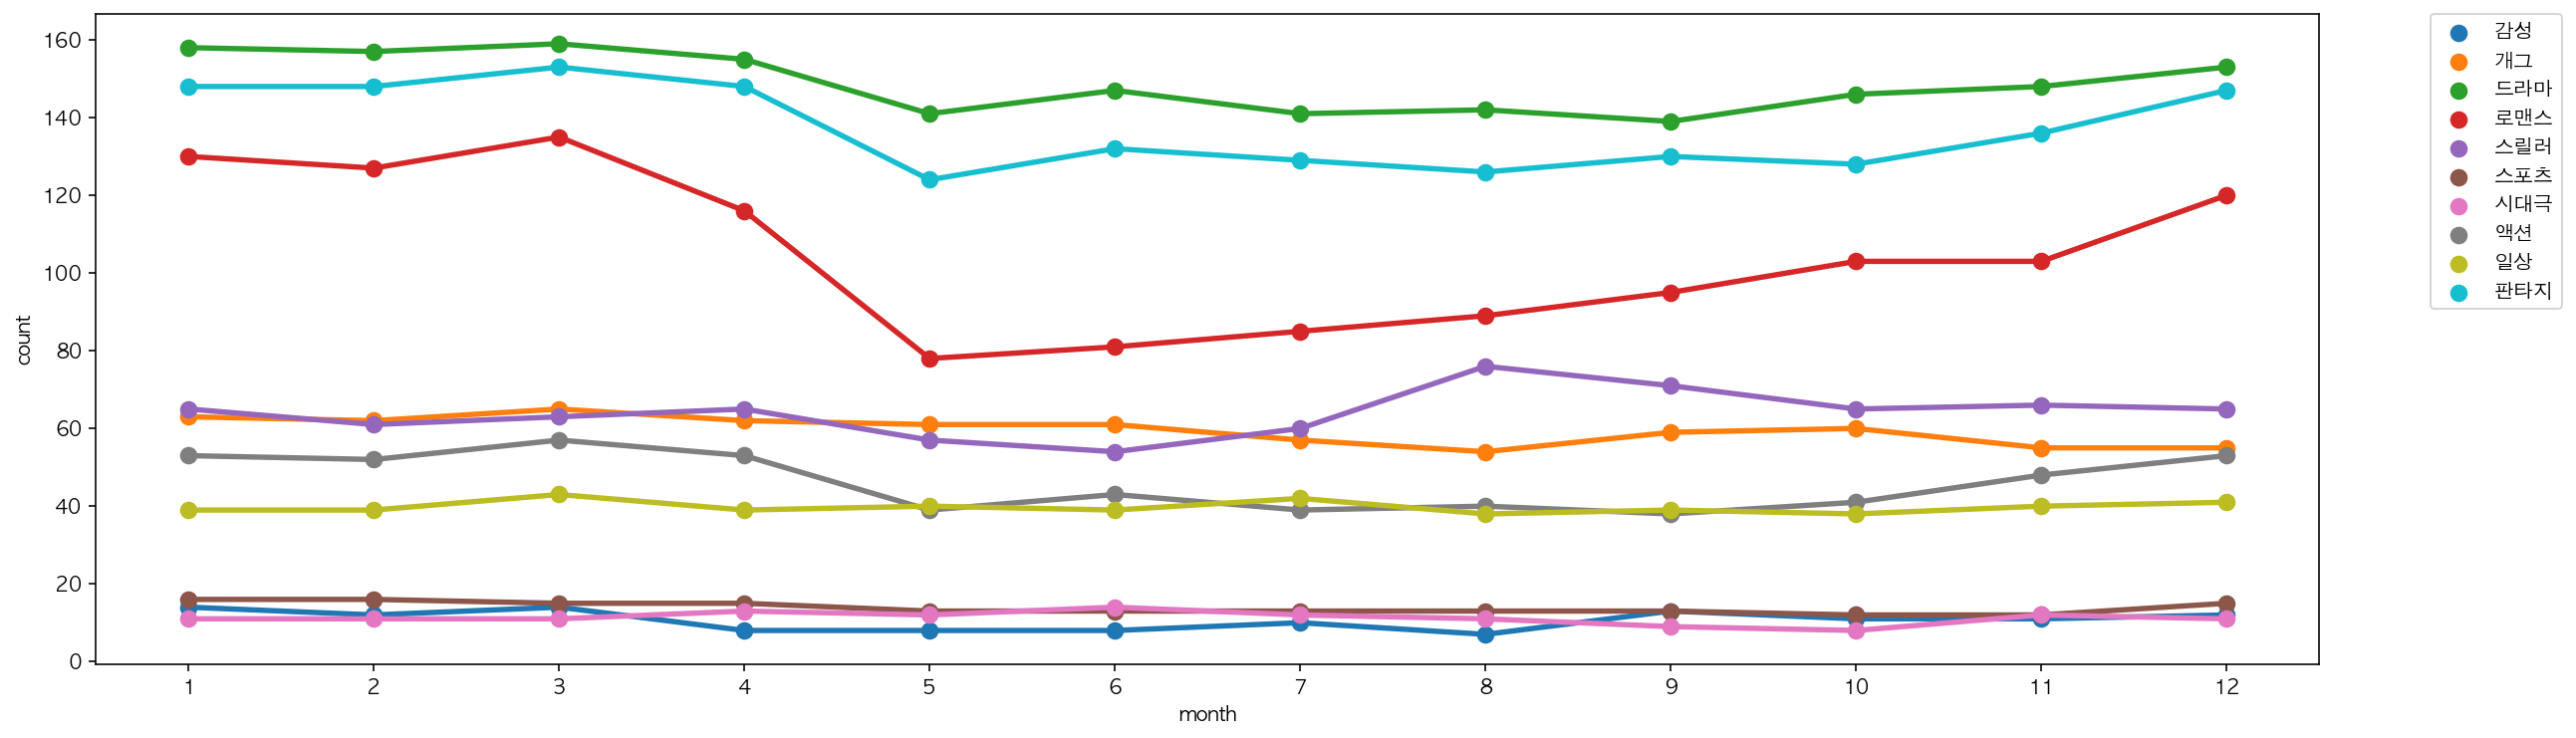

In [184]:
result = yearly_df.groupby(['title', 'genre2', 'month']).size().reset_index()[['title', 'genre2', 'month']].groupby(['genre2', 'month']).size().reset_index(name='count')

plt.figure(figsize=(20, 6))

sns.pointplot(data=result, x='month', y='count', hue='genre2')
plt.legend(bbox_to_anchor=(1.05, 1), borderaxespad=0, loc=2)
plt.show()

In [185]:
yearly_df.groupby(['title', 'genre2', 'month']).size().reset_index()[['title', 'genre2', 'month']].groupby(['genre2', 'month']).size().reset_index(name='count')

,genre2,month,count
0,감성,1,14
1,감성,2,12
2,감성,3,14
3,감성,4,8
4,감성,5,8
...,...,...,...
115,판타지,8,126
116,판타지,9,130
117,판타지,10,128
118,판타지,11,136


#### 각 장르별 count의 월별 비율을 만드는 함수

In [186]:
def get_ratio(row):
    return row['count'] / result[result['genre2'] == row['genre2']]['count'].sum()

In [187]:
result['ratio'] = result.apply(get_ratio, axis=1)
result

,genre2,month,count,ratio
0,감성,1,14,0.109375
1,감성,2,12,0.093750
2,감성,3,14,0.109375
3,감성,4,8,0.062500
4,감성,5,8,0.062500
...,...,...,...,...
115,판타지,8,126,0.076410
116,판타지,9,130,0.078836
117,판타지,10,128,0.077623
118,판타지,11,136,0.082474


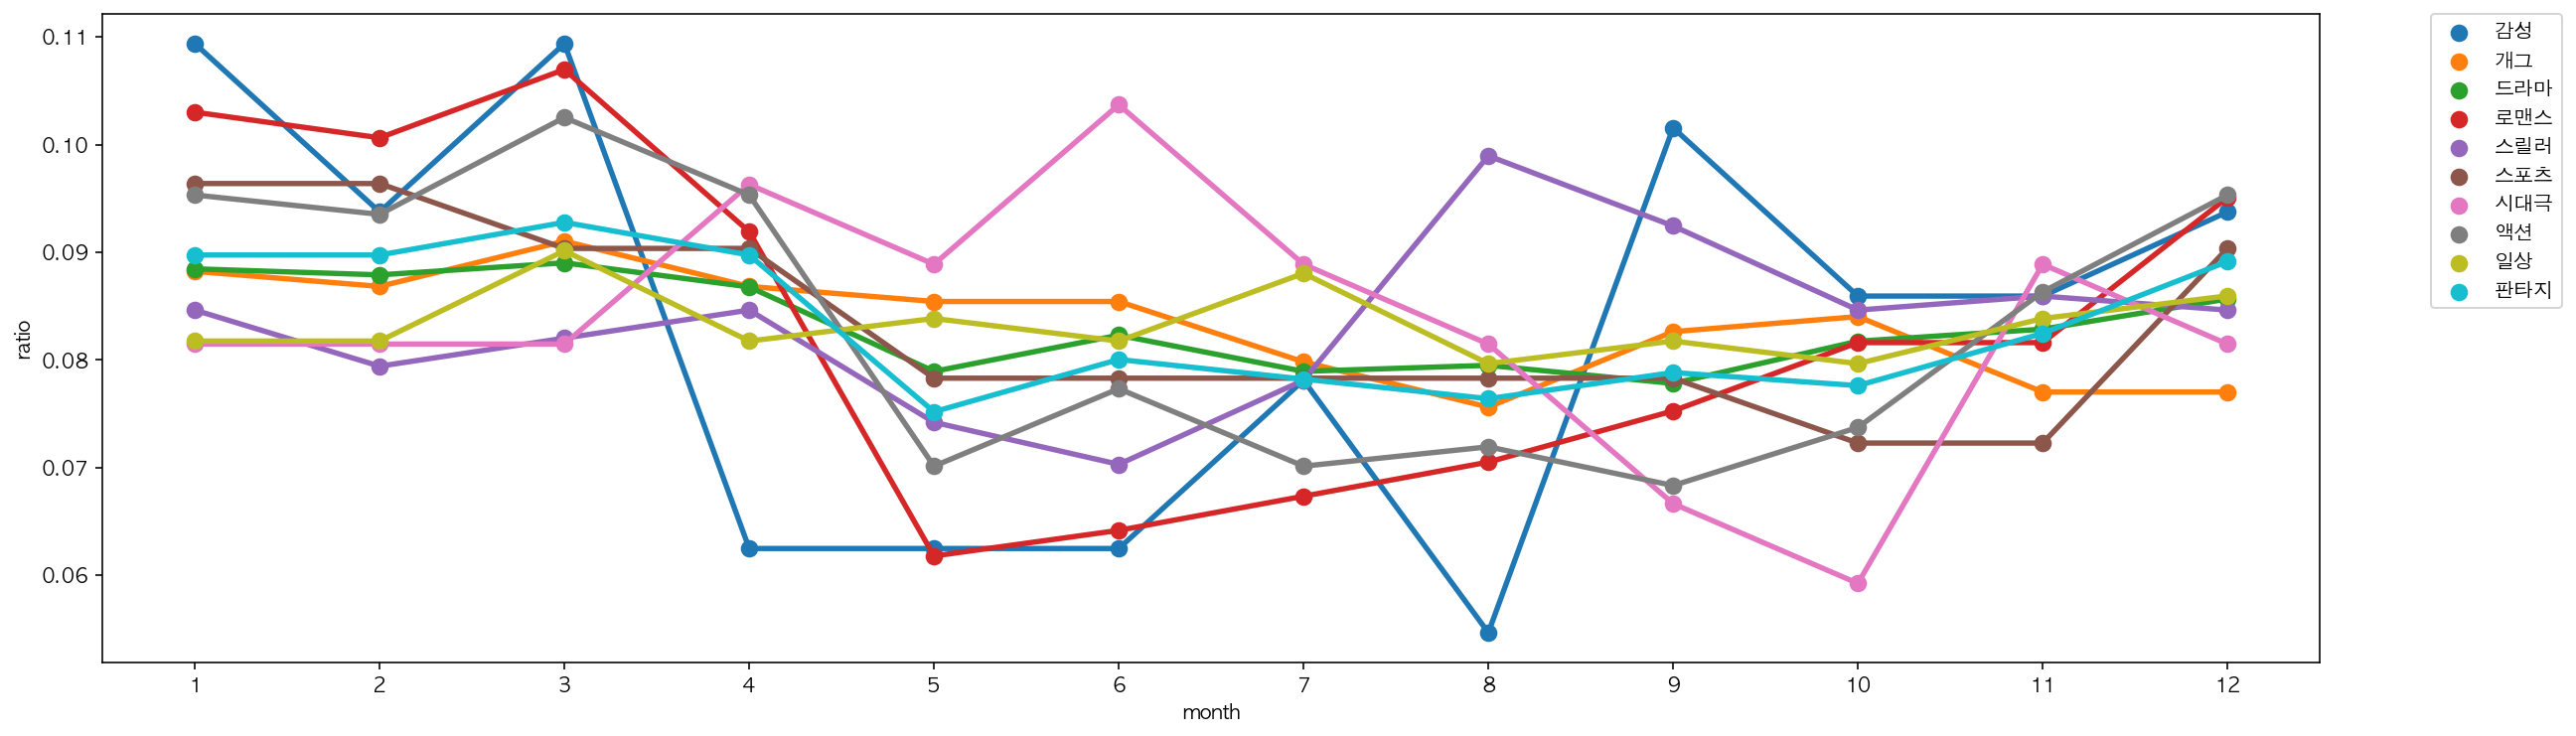

In [188]:
plt.figure(figsize=(20, 6))

sns.pointplot(data=result, x='month', y='ratio', hue='genre2')
plt.legend(bbox_to_anchor=(1.05, 1), borderaxespad=0, loc=2)
plt.show()

#### 위 그래프와 동일한 색상으로 장르지정

In [165]:
genres = result['genre2'].unique()

colors = {}
for idx, genre in enumerate(genre):
    colors[genre] = sns.color_palette()[idx]
    
colors

{'감성': (0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 '개그': (1.0, 0.4980392156862745, 0.054901960784313725),
 '드라마': (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 '로맨스': (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 '스릴러': (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 '스포츠': (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 '시대극': (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 '액션': (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 '일상': (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 '판타지': (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)}

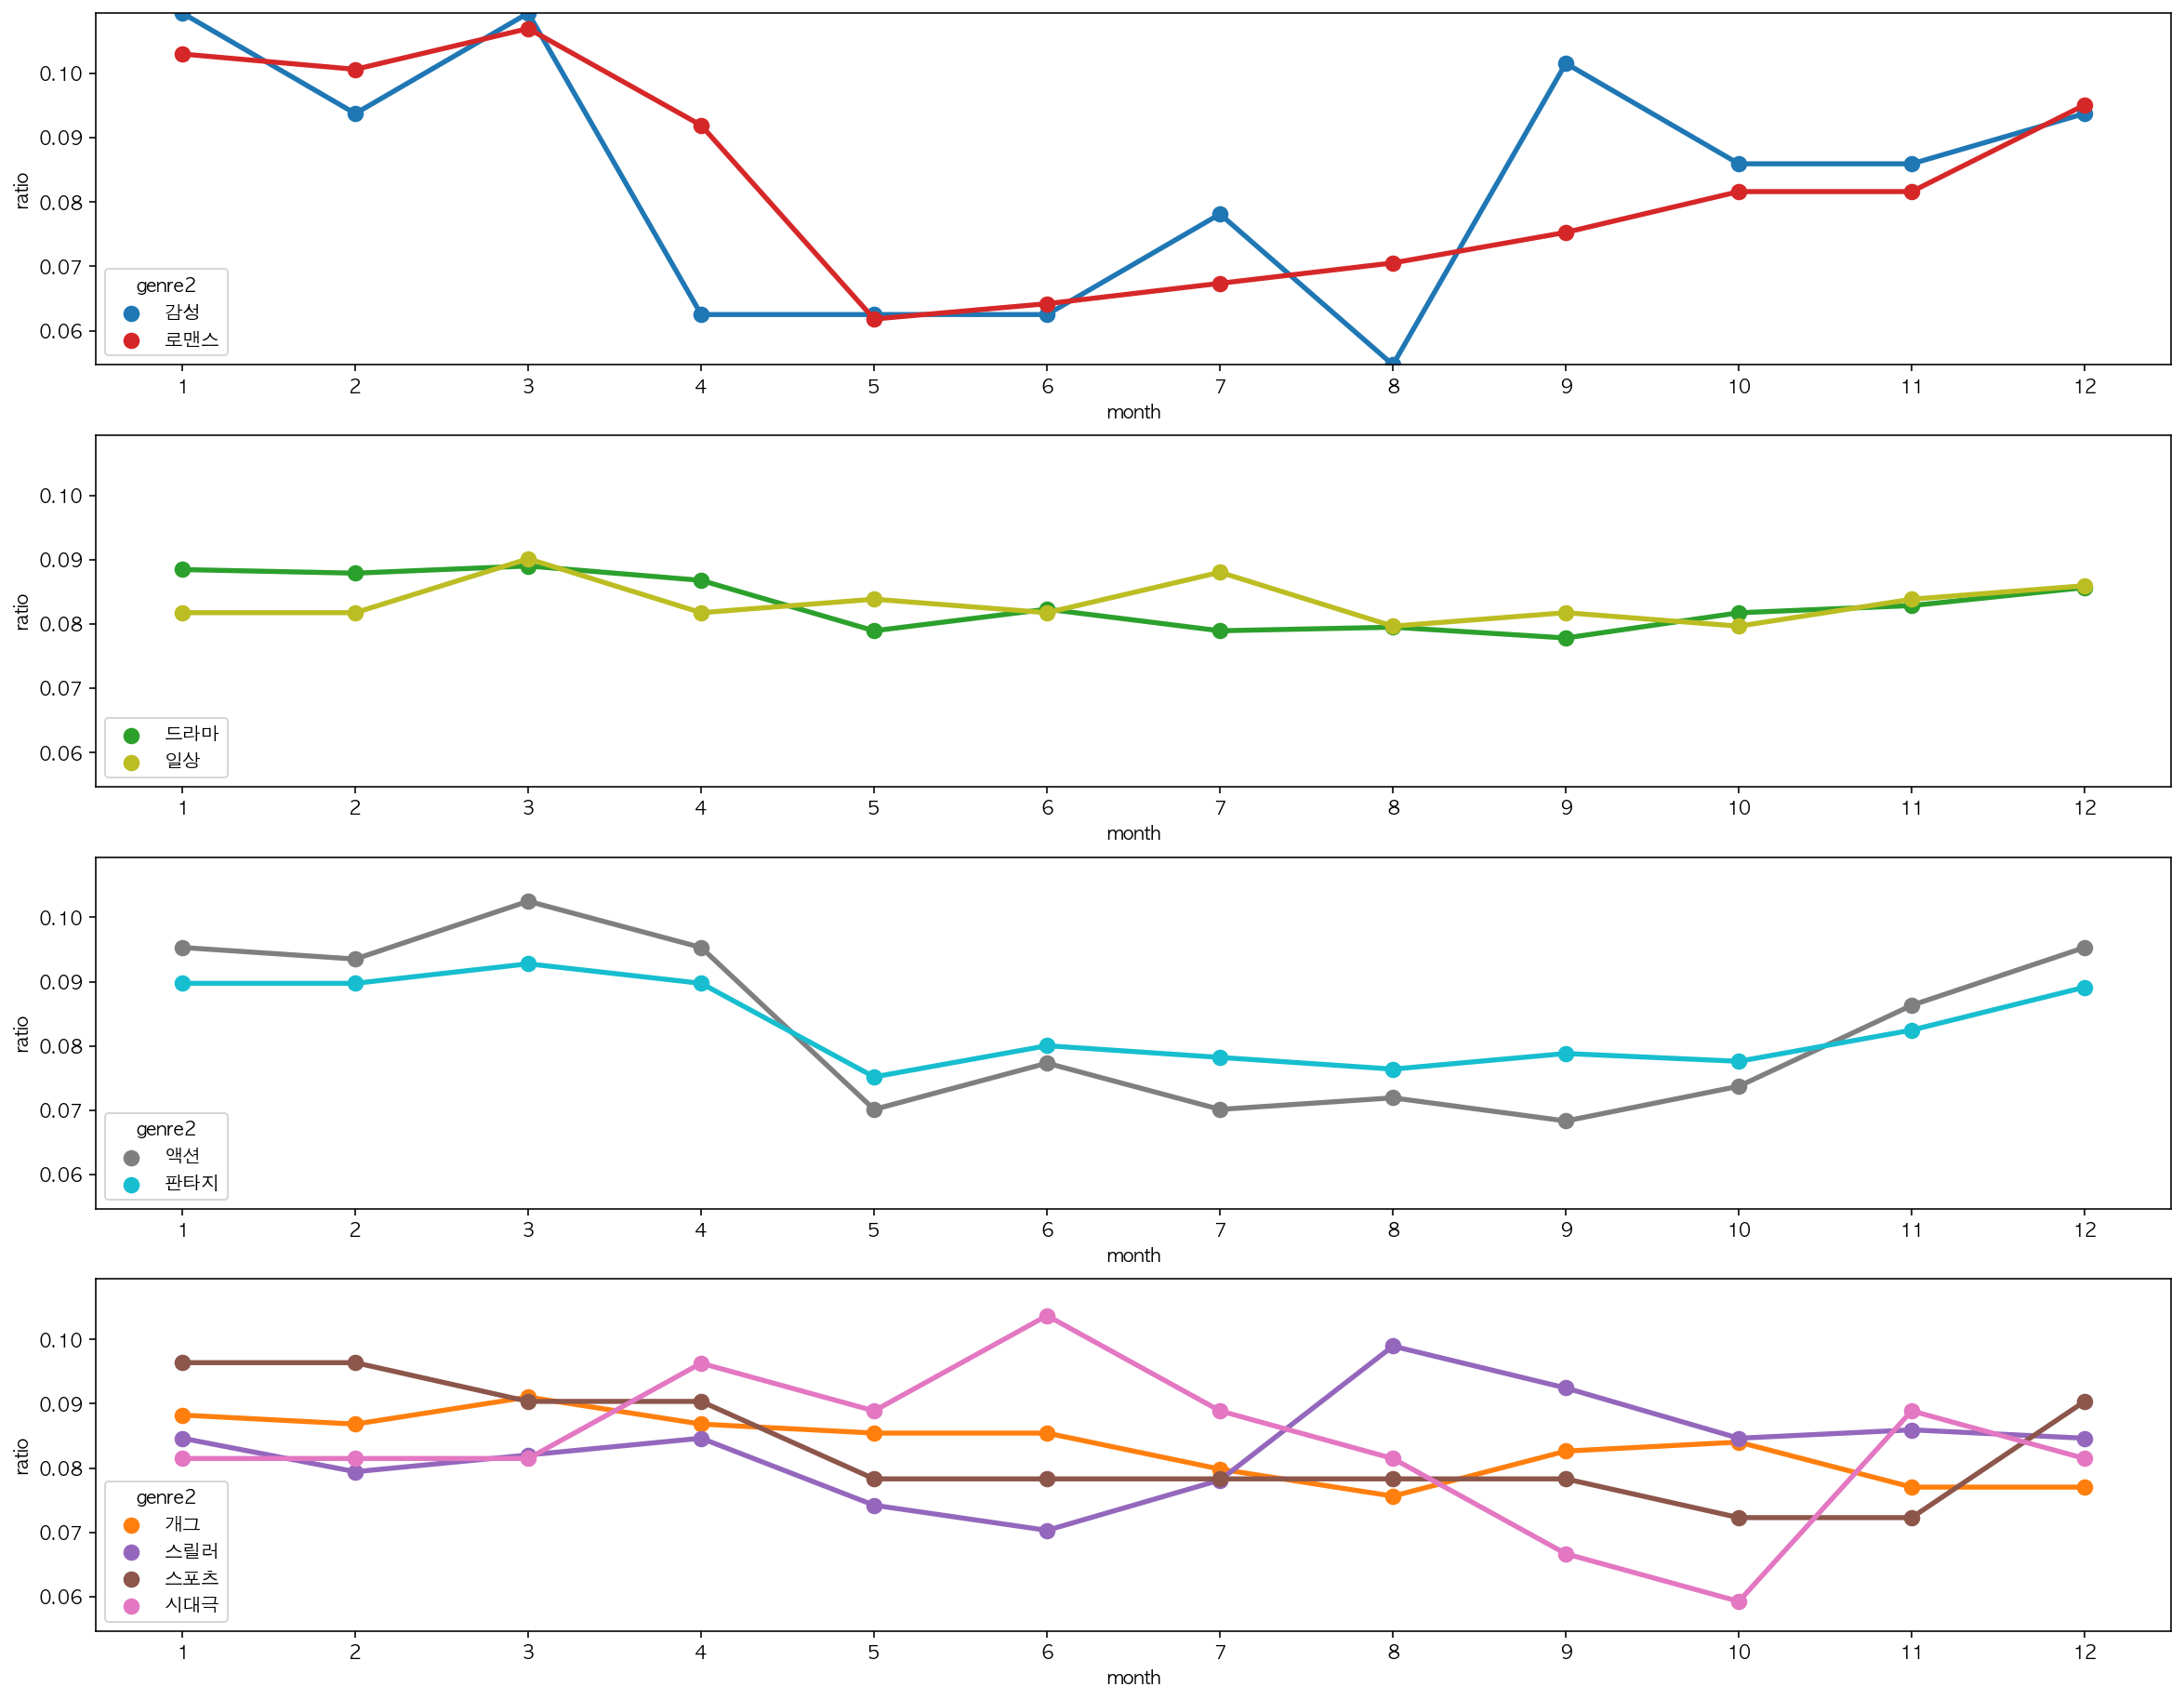

In [182]:
fig, ax = plt.subplots(4, 1, figsize=(20, 16))

sns.pointplot(data=result[result.isin(['감성', '로맨스'])['genre2']],
              x='month', y='ratio', hue='genre2', palette=[colors['감성'], colors['로맨스']], ax=ax[0])
sns.pointplot(data=result[result.isin(['드라마', '일상'])['genre2']],
              x='month', y='ratio', hue='genre2', palette=[colors['드라마'], colors['일상']], ax=ax[1])
sns.pointplot(data=result[result.isin(['액션', '판타지'])['genre2']],
              x='month', y='ratio', hue='genre2', palette=[colors['액션'], colors['판타지']], ax=ax[2])
sns.pointplot(data=result[result.isin(['개그', '스릴러', '스포츠', '시대극'])['genre2']],
              x='month', y='ratio', hue='genre2', palette=[colors['개그'], colors['스릴러'], colors['스포츠'], colors['시대극']], ax=ax[3])


ax[0].set(ylim=(result['ratio'].min(), result['ratio'].max()))
ax[1].set(ylim=(result['ratio'].min(), result['ratio'].max()))
ax[1].legend(loc='lower left')
ax[2].set(ylim=(result['ratio'].min(), result['ratio'].max()))
ax[3].set(ylim=(result['ratio'].min(), result['ratio'].max()))

plt.show()

-> 로맨스와 로맨스와 비슷한 장르인 감성의 웹툰이 가을에 인기있을 줄 알았지만 1 ~ 4월, 봄에 더 인기가 많았다고 할 수 있다.

-> 나머지 장르에서는 대체로 고루 퍼져있는 것을 알 수 있다.